## Import Library & File

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('future.no_silent_downcasting', True)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


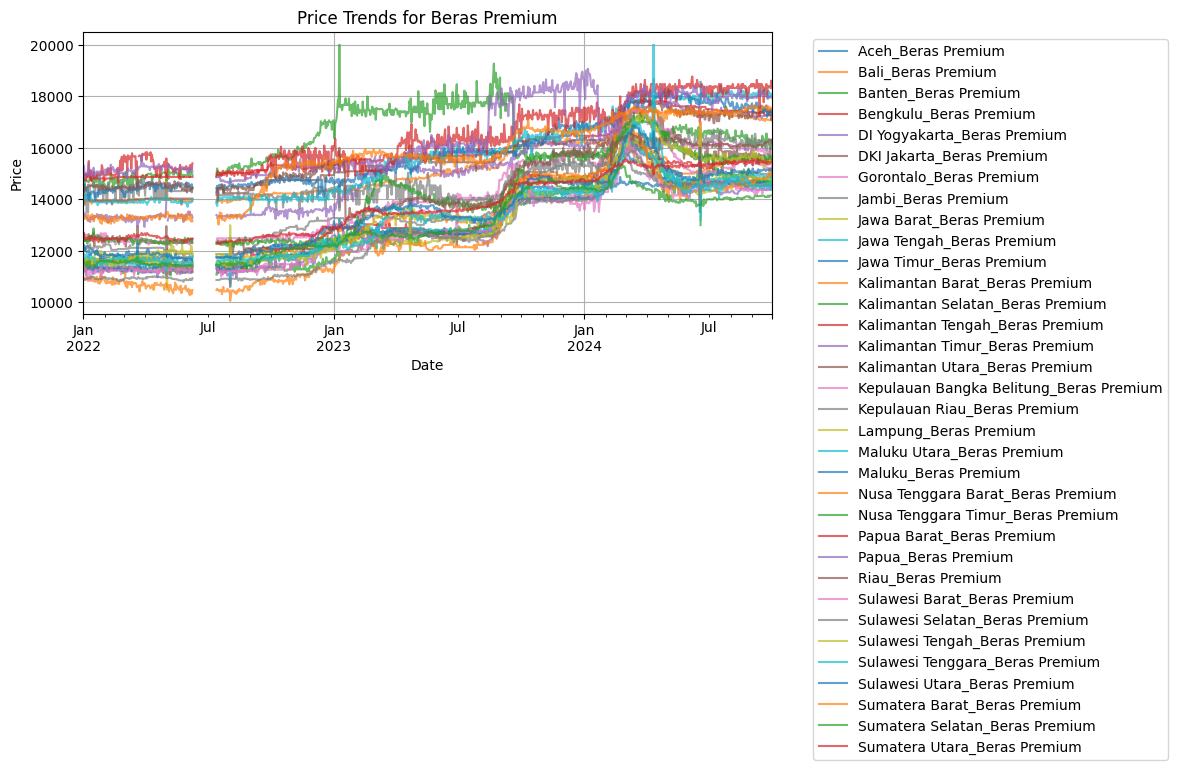

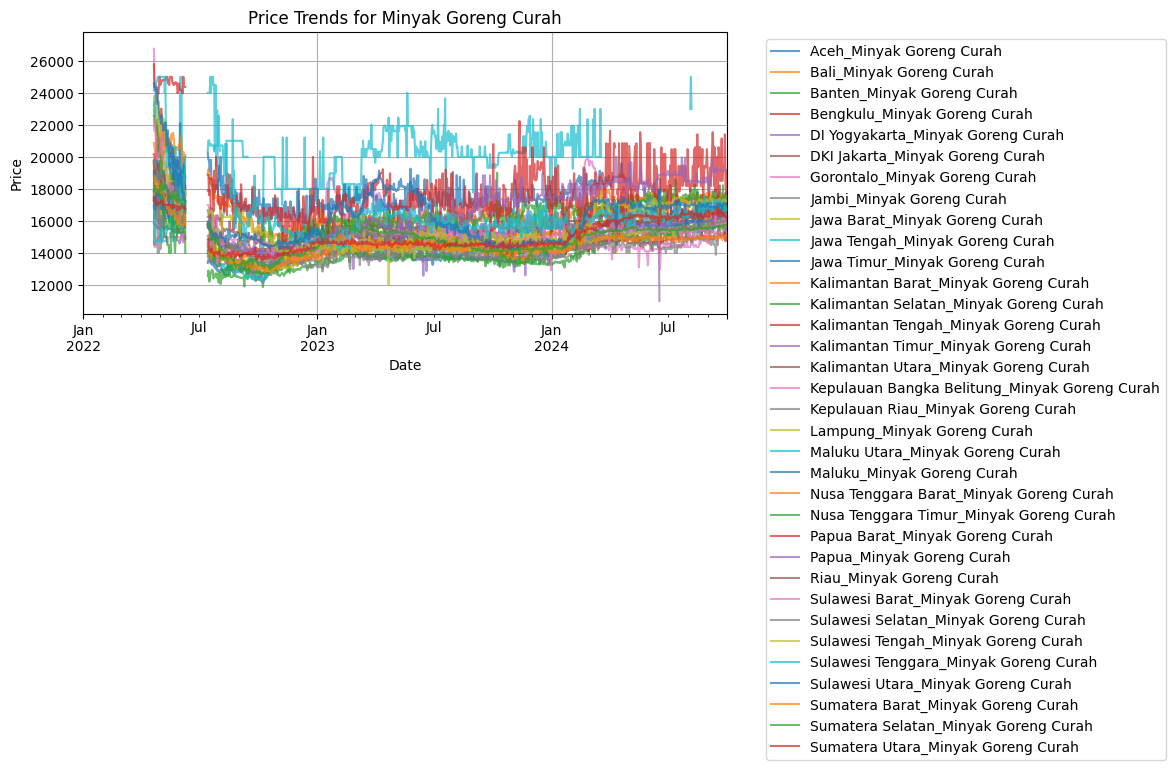

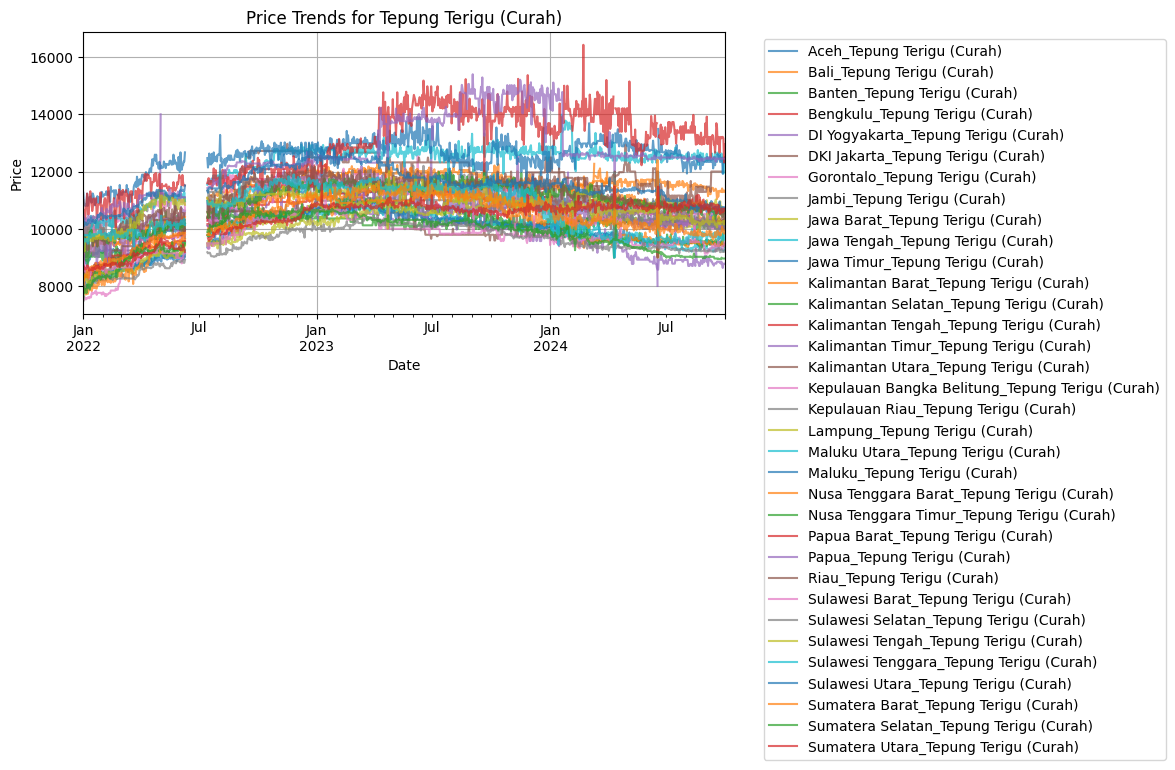

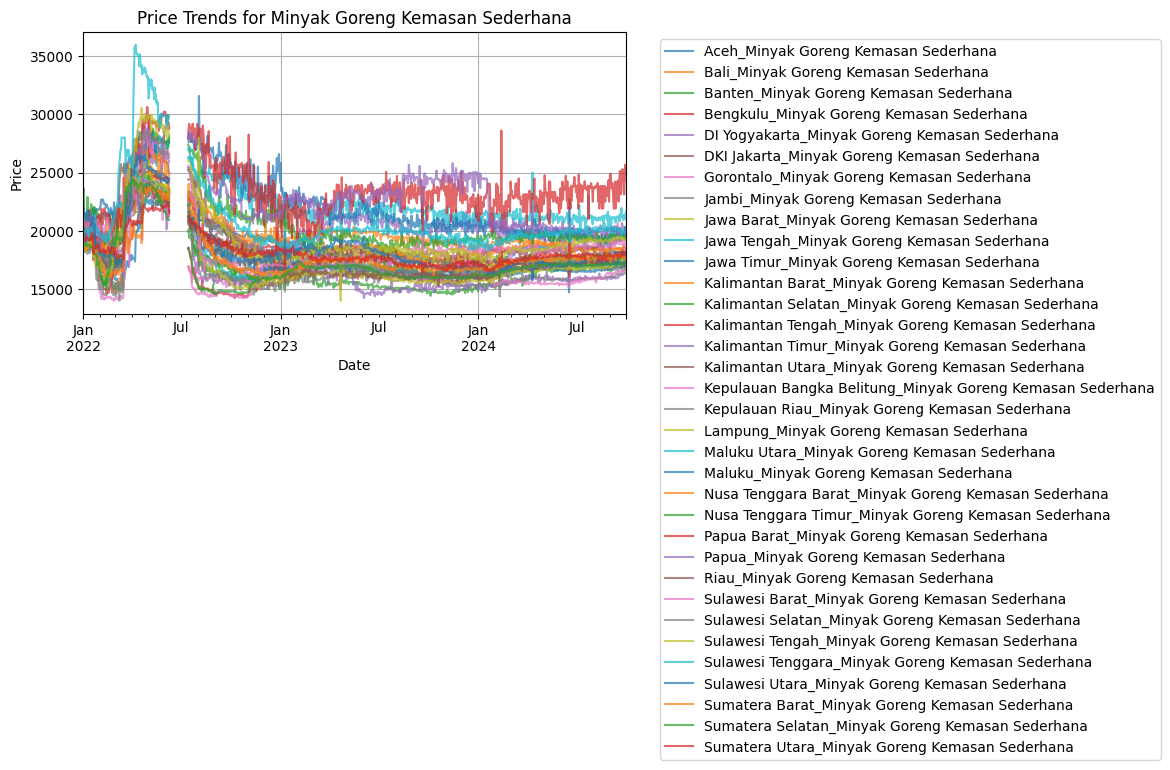

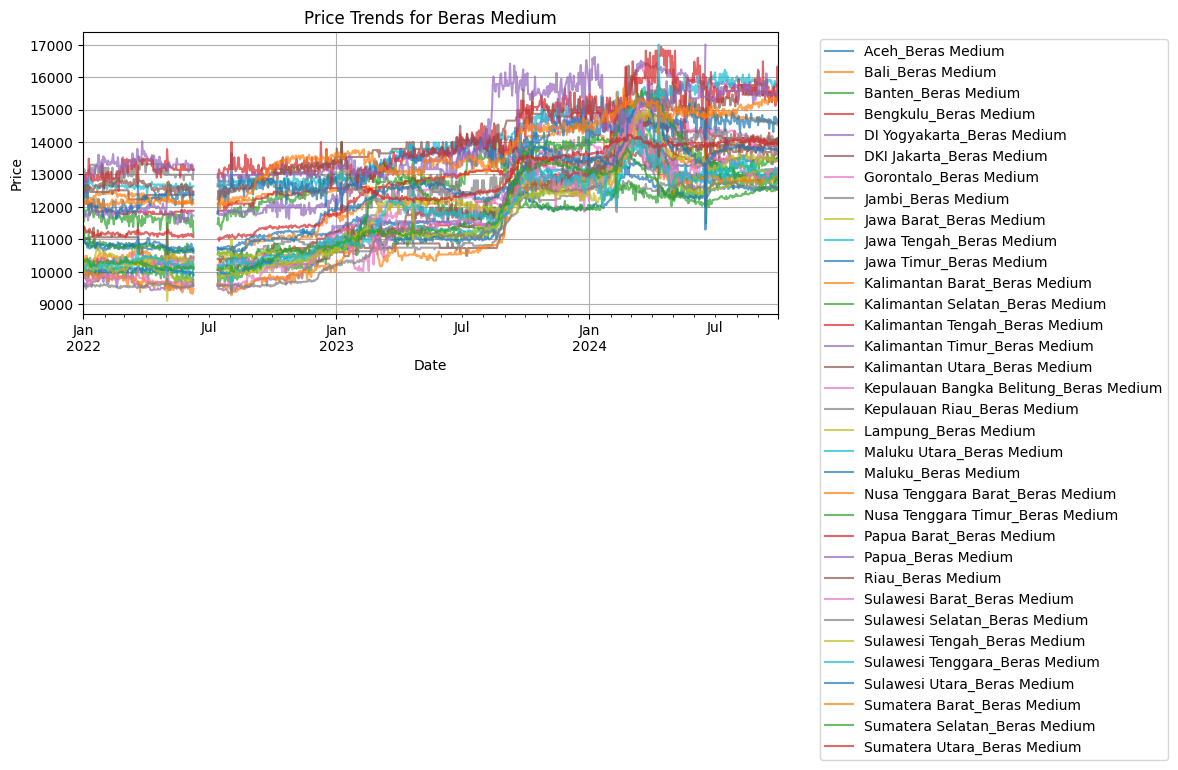

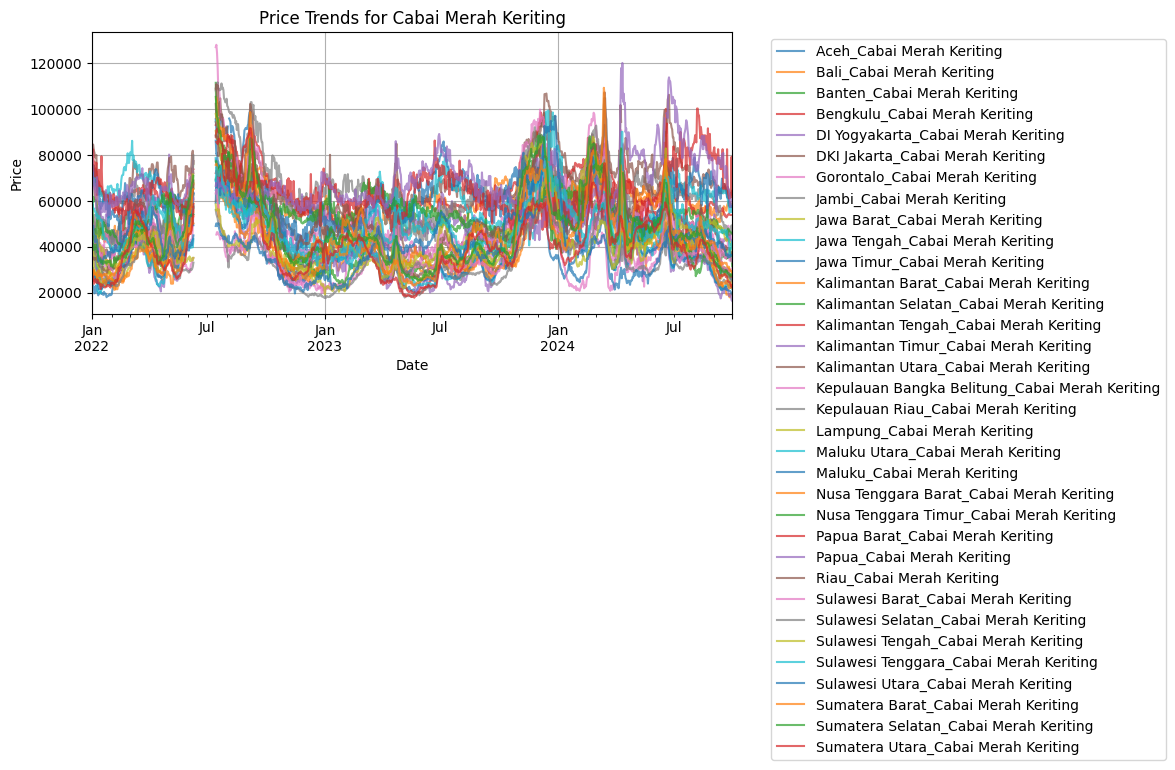

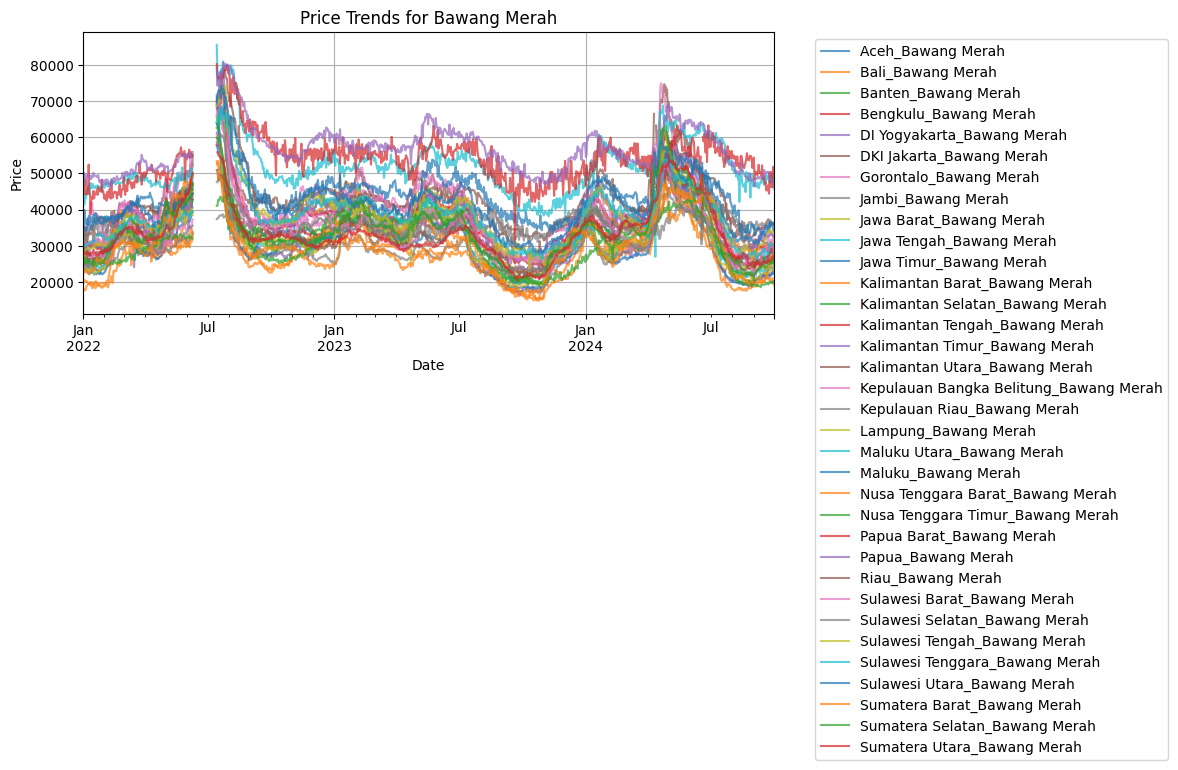

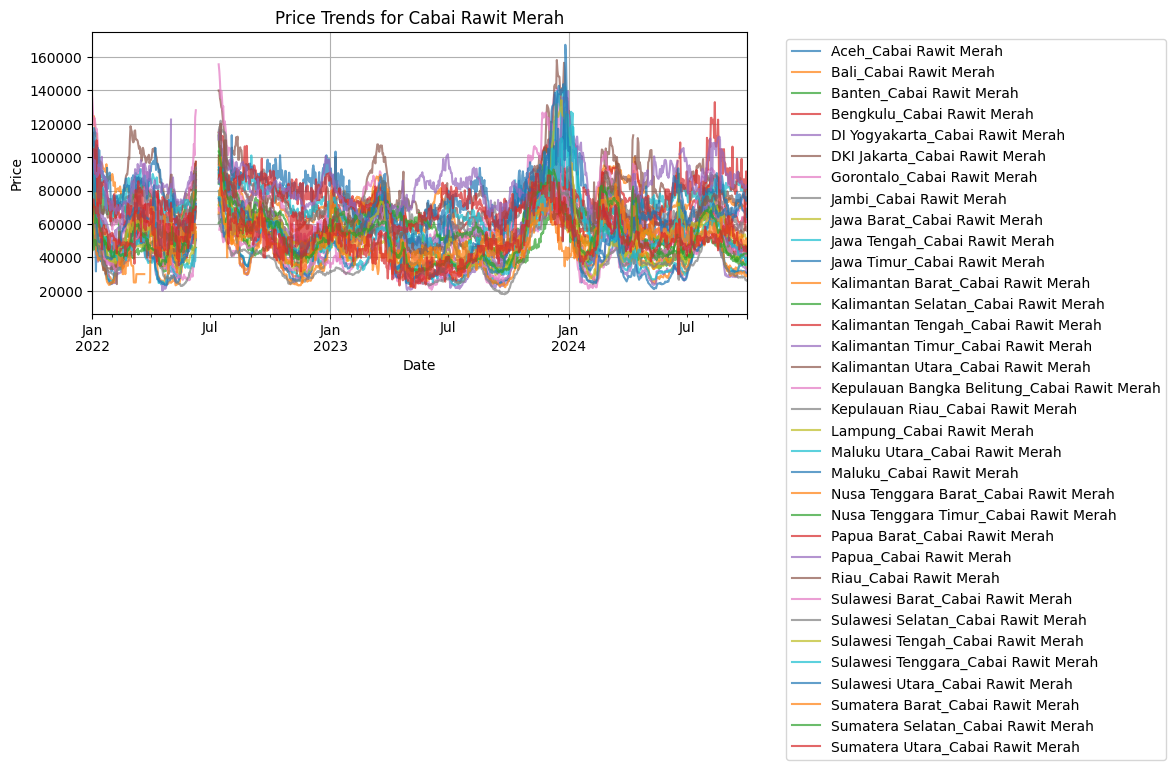

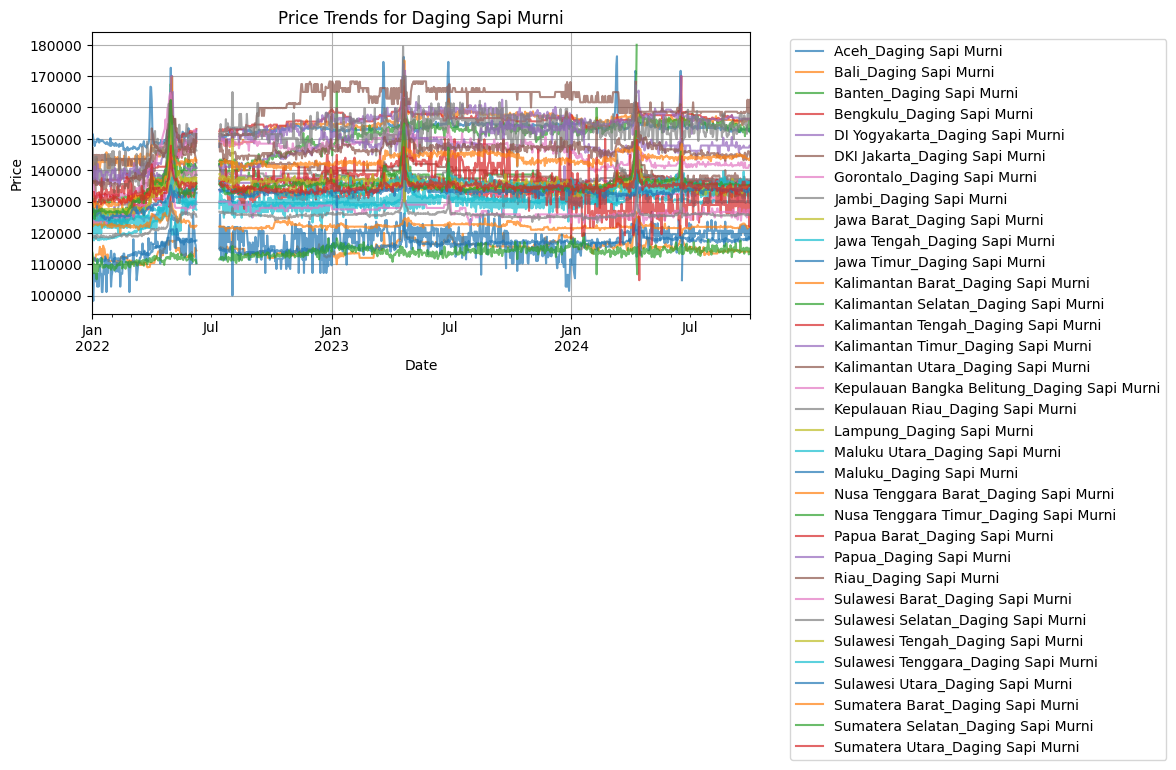

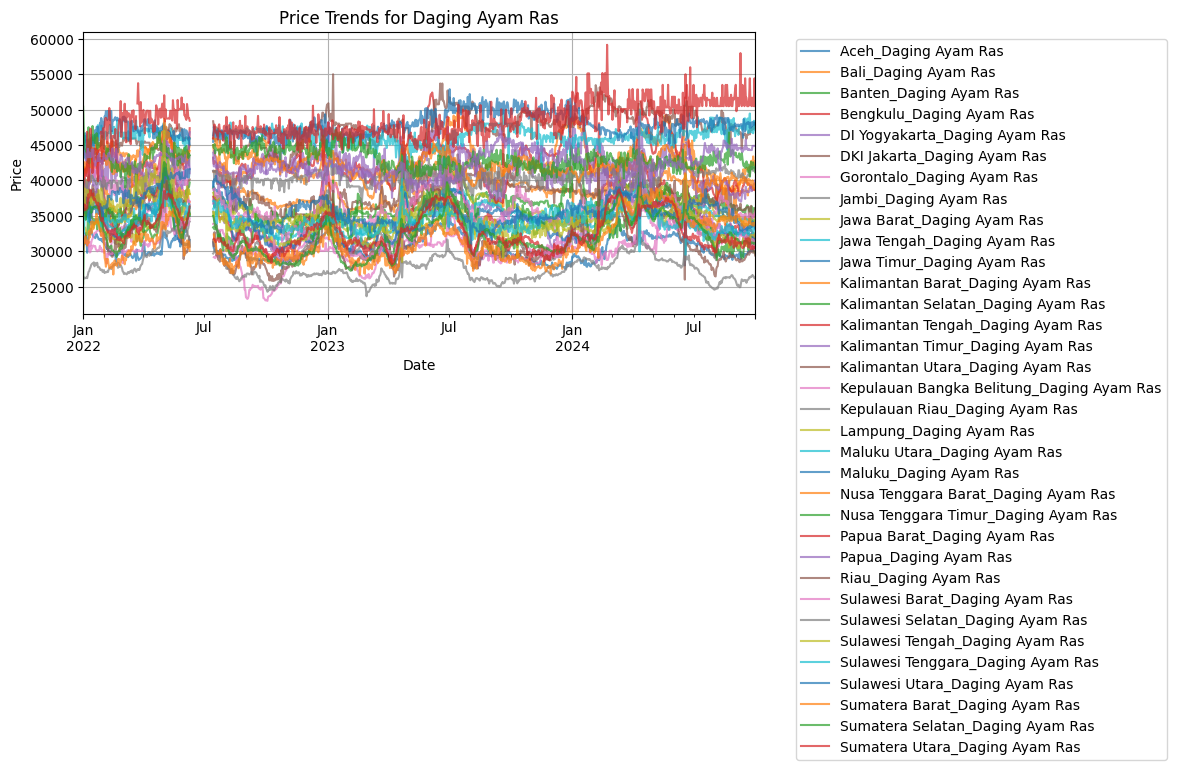

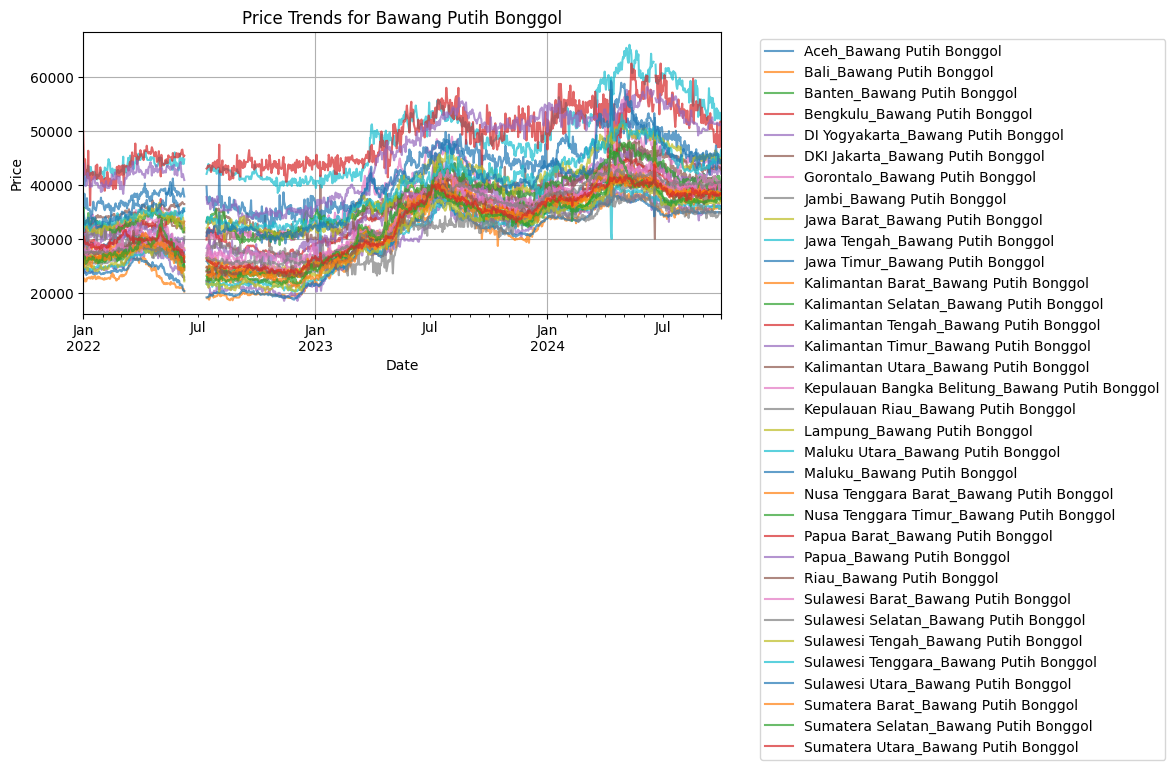

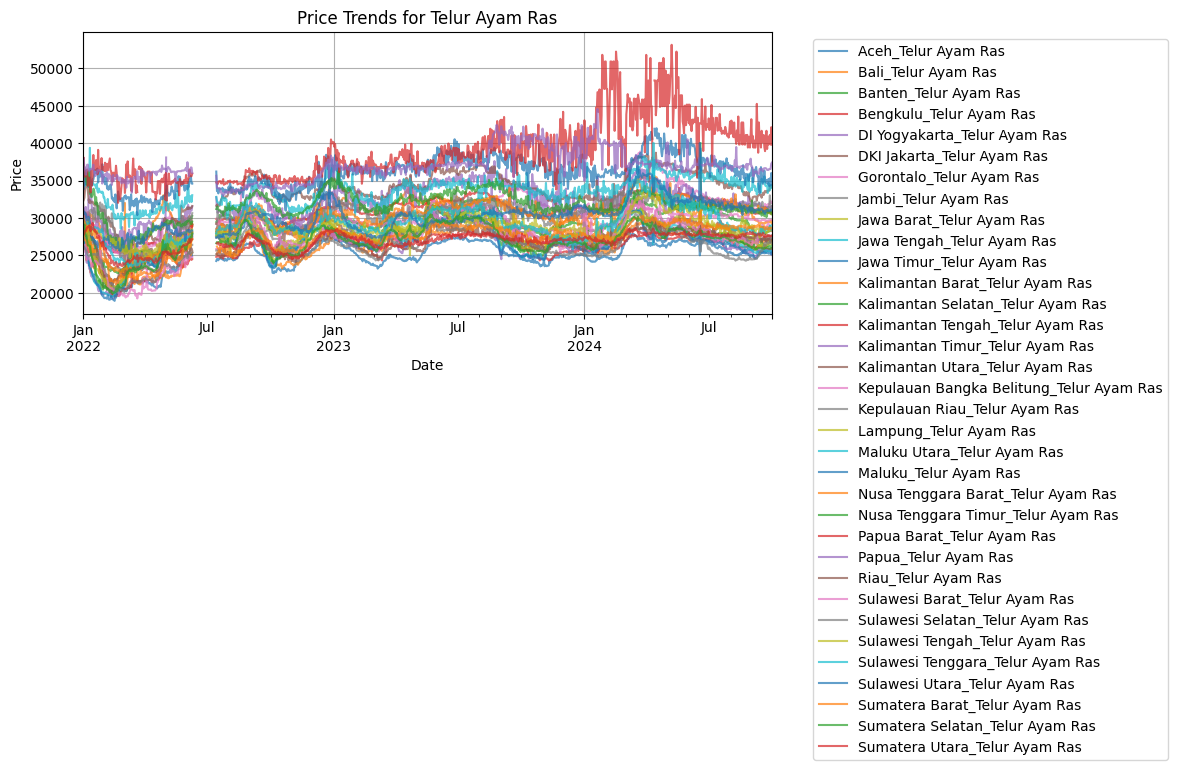

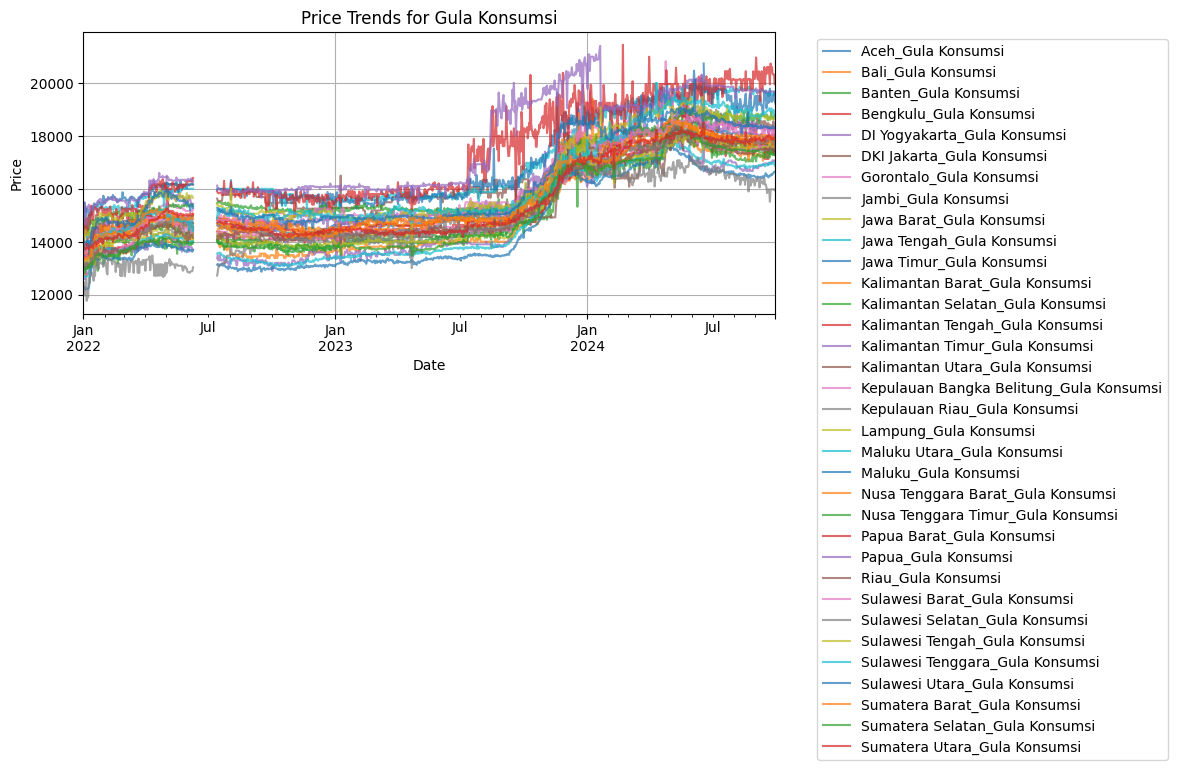

In [5]:
# Path ke folder data
train_folder = '/kaggle/input/comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan/train'

# List semua file CSV di dalam folder
files = [f for f in os.listdir(train_folder) if f.endswith('.csv')]

# Dictionary untuk menyimpan setiap data komoditas
data_dict = {}

for file in files:
    # Baca CSV
    temp_df = pd.read_csv(os.path.join(train_folder, file))
    
    # Tambahkan nama komoditas
    commodity_name = file.replace('.csv', '')
    
    # Ubah format provinsi agar menjadi kolom unik
    temp_df = temp_df.rename(columns={col: f"{col}_{commodity_name}" for col in temp_df.columns if col != 'Date'})

    # Simpan ke dictionary
    data_dict[commodity_name] = temp_df

# Gabungkan semua dataset berdasarkan 'date'
df = list(data_dict.values())[0]
for key in list(data_dict.keys())[1:]:
    df = df.merge(data_dict[key], on='Date', how='outer')

# Konversi date ke datetime
df['Date'] = pd.to_datetime(df['Date'])

# Load the DataFrame
df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
df.set_index('Date', inplace=True)  # Set Date as index

# Extract unique commodities by splitting column names
commodities = set(col.split('_')[-1] for col in df.columns)

# Plot each commodity separately
for commodity in commodities:
    plt.figure(figsize=(12, 6))

    # Select all columns that belong to the same commodity
    selected_columns = [col for col in df.columns if commodity in col]
    
    # Plot all 35 provinces for this commodity
    df[selected_columns].plot(ax=plt.gca(), linewidth=1.5, alpha=0.7)

    plt.title(f'Price Trends for {commodity}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(selected_columns, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    
    plt.show()  # Show each plot separately


Karena pada semua dataset terdapat missing value dari 10 juni 2022 - 13 juli 2022, dan sebelum tanggal 21 april 2022 untuk minyak goreng curah, maka kami akan menghapus data sebelum bulan agustus 2022

## Preprocess

In [6]:
import pandas as pd
from pathlib import Path
train_path = Path("/kaggle/input/comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan/train")
test_path = Path("/kaggle/input/comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan/test")
# Path configurations
data_path = Path("/kaggle/input/comodity-price-prediction-penyisihan-arkavidia-9")
commodity_path = data_path / "Global Commodity Price"
currency_path = data_path / "Mata Uang"

def load_exogenous_data():
    # Load global commodity prices
    commodity_files = [
        "Crude Oil WTI Futures Historical Data.csv",
        "Natural Gas Futures Historical Data.csv",
        "Newcastle Coal Futures Historical Data.csv",
      #  "Palm Oil Futures Historical Data.csv",
        "US Sugar 11 Futures Historical Data.csv",
   #     "US Wheat Futures Historical Data.csv"
    ]
    
    commodity_dfs = []
    for file in commodity_files:
        df = pd.read_csv(commodity_path / file)
        commodity_name = file.split(" Futures")[0].replace(" ", "_")
        df = df[['Date', 'Price']].rename(columns={'Price': commodity_name})
        df['Date'] = pd.to_datetime(df['Date'])
        commodity_dfs.append(df)
    
    # Merge all commodity data
    commodity_df = commodity_dfs[0]
    for df in commodity_dfs[1:]:
        commodity_df = pd.merge(commodity_df, df, on='Date', how='outer')
    
    # Load currency data
    currency_df = pd.read_csv(currency_path / "USDIDR=X.csv")
    currency_df = currency_df[['Date', 'Close']].rename(columns={'Close': 'USD_IDR'})
    currency_df['Date'] = pd.to_datetime(currency_df['Date'])
    
    # Merge commodity and currency data
    exogenous_df = pd.merge(commodity_df, currency_df, on='Date', how='outer')
    
    # Forward fill missing values
    exogenous_df = exogenous_df.sort_values('Date').ffill()
    
    return exogenous_df

# Modified process_file function with exogenous data
def process_file_with_exog(file_path, exogenous_df, is_train=True):
    """Process individual food file with exogenous variables"""
    df = pd.read_csv(file_path)
    pangan = file_path.stem
    
    processed = df.melt(id_vars='Date', var_name='provinsi', value_name='y') \
                .assign(ds=lambda x: pd.to_datetime(x['Date']),
                        unique_id=lambda x: pangan + '/' + x['provinsi']) \
                .drop(columns=['Date', 'provinsi'])
    
    if is_train:
        # Remove < July 2022 data
        processed = processed[~((processed.ds.dt.year == 2022) & 
                              (processed.ds.dt.month <= 7))]
        
        # Calculate date-food average for imputation
        date_avg = processed.groupby('ds')['y'].transform('mean')
        processed['y'] = processed['y'].fillna(date_avg)
        processed.dropna(subset=['y'], inplace=True)
    
    # Merge with exogenous data
    processed = pd.merge(processed, exogenous_df, 
                        left_on='ds', right_on='Date', how='left') \
                .drop(columns=['Date']) \
                .ffill()  # Forward fill any remaining missing
    
    return processed


# Menambahkan data libur nasional 
holiday_dates = set()

# Add 2022 holidays
holiday_dates.update({
    '2022-01-01', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-14',
    '2022-03-11', '2022-03-12', '2022-03-29', '2022-04-10', '2022-05-01',
    '2022-05-09', '2022-05-10', '2022-05-23', '2022-05-24', '2022-06-01',
    '2022-06-17', '2022-06-18', '2022-07-07', '2022-08-17', '2022-09-16',
    '2022-11-27', '2022-12-25', '2022-12-26'
})
holiday_dates.update(f'2022-04-{d:02}' for d in range(8,10))    # 08-09 Apr
holiday_dates.update(f'2022-04-{d:02}' for d in range(11,16))   # 11-15 Apr

# Add 2023 holidays
holiday_dates.update({
    '2023-01-01', '2023-01-22', '2023-01-23', '2023-02-18', '2023-03-22',
    '2023-03-23', '2023-04-07', '2023-04-22', '2023-05-01', '2023-05-18',
    '2023-06-01', '2023-06-02', '2023-06-04', '2023-06-28', '2023-06-29',
    '2023-06-30', '2023-07-19', '2023-08-17', '2023-09-28', '2023-12-25',
    '2023-12-26'
})
holiday_dates.update(f'2023-04-{d:02}' for d in range(19,22))   # 19-21 Apr
holiday_dates.update(f'2023-04-{d:02}' for d in range(23,26))   # 23-25 Apr

# Add 2024 holidays
holiday_dates.update({
    '2024-01-01', '2024-02-08', '2024-02-09', '2024-02-10', '2024-02-14',
    '2024-03-11', '2024-03-12', '2024-03-29', '2024-04-10', '2024-05-01',
    '2024-05-09', '2024-05-10', '2024-05-23', '2024-05-24', '2024-06-01',
    '2024-06-17', '2024-06-18', '2024-07-07', '2024-08-17', '2024-09-16',
    '2024-11-27', '2024-12-25', '2024-12-26'
})
holiday_dates.update(f'2024-04-{d:02}' for d in range(8,10))    # 08-09 Apr
holiday_dates.update(f'2024-04-{d:02}' for d in range(11,16))   # 11-15 Apr

# Convert to datetime
holiday_dates = {pd.to_datetime(d) for d in holiday_dates}

def add_holiday_feature(df):
    """Add is_holiday feature to dataframe"""
    df = df.copy()
    df['is_holiday'] = df['ds'].isin(holiday_dates).astype(int)
    
    # Add holiday flags for previous and next days
    df['prev_day_holiday'] = df['ds'].shift(1).isin(holiday_dates).astype(int)
    df['next_day_holiday'] = df['ds'].shift(-1).isin(holiday_dates).astype(int)
    
    return df
# Main processing with exogenous variables
exogenous_df = load_exogenous_data()

# Modify your process_file_with_exog function
def process_file_with_exog_and_holidays(file_path, exogenous_df, is_train=True):
    """Process file with exog data and holiday features"""
    processed = process_file_with_exog(file_path, exogenous_df, is_train)
    processed = add_holiday_feature(processed)
    return processed

# Update hist_exog_features
#hist_exog_features += ['is_holiday', 'prev_day_holiday', 'next_day_holiday']

# When processing data:
all_train = []
all_test = []

for train_file in train_path.glob("*.csv"):
    train_df = process_file_with_exog_and_holidays(train_file, exogenous_df)
    all_train.append(train_df)

for test_file in test_path.glob("*.csv"):
    test_df = process_file_with_exog_and_holidays(test_file, exogenous_df, False)
    all_test.append(test_df)


# Combine datasets
train_df = pd.concat(all_train)
test_df = pd.concat(all_test)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350064 entries, 0 to 26927
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   y                 350064 non-null  float64       
 1   ds                350064 non-null  datetime64[ns]
 2   unique_id         350064 non-null  object        
 3   Crude_Oil_WTI     350064 non-null  float64       
 4   Natural_Gas       350064 non-null  float64       
 5   Newcastle_Coal    350064 non-null  float64       
 6   US_Sugar_11       350064 non-null  float64       
 7   USD_IDR           350064 non-null  float64       
 8   is_holiday        350064 non-null  int64         
 9   prev_day_holiday  350064 non-null  int64         
 10  next_day_holiday  350064 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 32.0+ MB


In [24]:
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


y         ds                            unique_id  Crude_Oil_WTI  \
0     0.0 2024-10-01                 Daging Ayam Ras/Aceh            NaN   
1     0.0 2024-10-02                 Daging Ayam Ras/Aceh            NaN   
2     0.0 2024-10-03                 Daging Ayam Ras/Aceh            NaN   
3     0.0 2024-10-04                 Daging Ayam Ras/Aceh            NaN   
4     0.0 2024-10-05                 Daging Ayam Ras/Aceh            NaN   
...   ...        ...                                  ...            ...   
3123  0.0 2024-12-27  Cabai Merah Keriting/Sumatera Utara            NaN   
3124  0.0 2024-12-28  Cabai Merah Keriting/Sumatera Utara            NaN   
3125  0.0 2024-12-29  Cabai Merah Keriting/Sumatera Utara            NaN   
3126  0.0 2024-12-30  Cabai Merah Keriting/Sumatera Utara            NaN   
3127  0.0 2024-12-31  Cabai Merah Keriting/Sumatera Utara            NaN   

      Natural_Gas  Newcastle_Coal  US_Sugar_11  USD_IDR  is_holiday  \
0             NaN             NaN          NaN      NaN           0   
1             NaN             NaN          NaN      NaN           0   
2             NaN             NaN          NaN      NaN           0   
3             NaN             NaN          NaN      NaN           0   
4             NaN             NaN          NaN      NaN           0   
...           ...             ...          ...      ...         ...   
3123          NaN             NaN          NaN      NaN           0   
3124          NaN             NaN          NaN      NaN           0   
3125          NaN             NaN          NaN      NaN           0   
3126          NaN             NaN          NaN      NaN           0   
3127          NaN             NaN          NaN      NaN           0   

      prev_day_holiday  next_day_holiday  
0                    0                 0  
1                    0                 0  
2                    0                 0  
3                    0                 0  
4                    0                 0  
...                ...               ...  
3123                 1                 0  
3124                 0                 0  
3125                 0                 0  
3126                 0                 0  
3127                 0                 0  

[40664 rows x 11 columns]

## EDA

In [25]:
train_df['unique_id'].value_counts()

unique_id
Daging Ayam Ras/Aceh                     792
Minyak Goreng Curah/Lampung              792
Minyak Goreng Curah/Sulawesi Tenggara    792
Minyak Goreng Curah/Sulawesi Tengah      792
Minyak Goreng Curah/Sulawesi Selatan     792
                                        ... 
Gula Konsumsi/Jawa Barat                 792
Gula Konsumsi/Jambi                      792
Gula Konsumsi/Gorontalo                  792
Gula Konsumsi/DKI Jakarta                792
Cabai Merah Keriting/Sumatera Utara      792
Name: count, Length: 442, dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325705 entries, 0 to 26927
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   y                 325705 non-null  float64       
 1   ds                325705 non-null  datetime64[ns]
 2   unique_id         325705 non-null  object        
 3   Crude_Oil_WTI     325705 non-null  float64       
 4   Natural_Gas       325705 non-null  float64       
 5   Newcastle_Coal    325705 non-null  float64       
 6   US_Sugar_11       325705 non-null  float64       
 7   USD_IDR           325705 non-null  float64       
 8   is_holiday        325705 non-null  int64         
 9   prev_day_holiday  325705 non-null  int64         
 10  next_day_holiday  325705 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 29.8+ MB


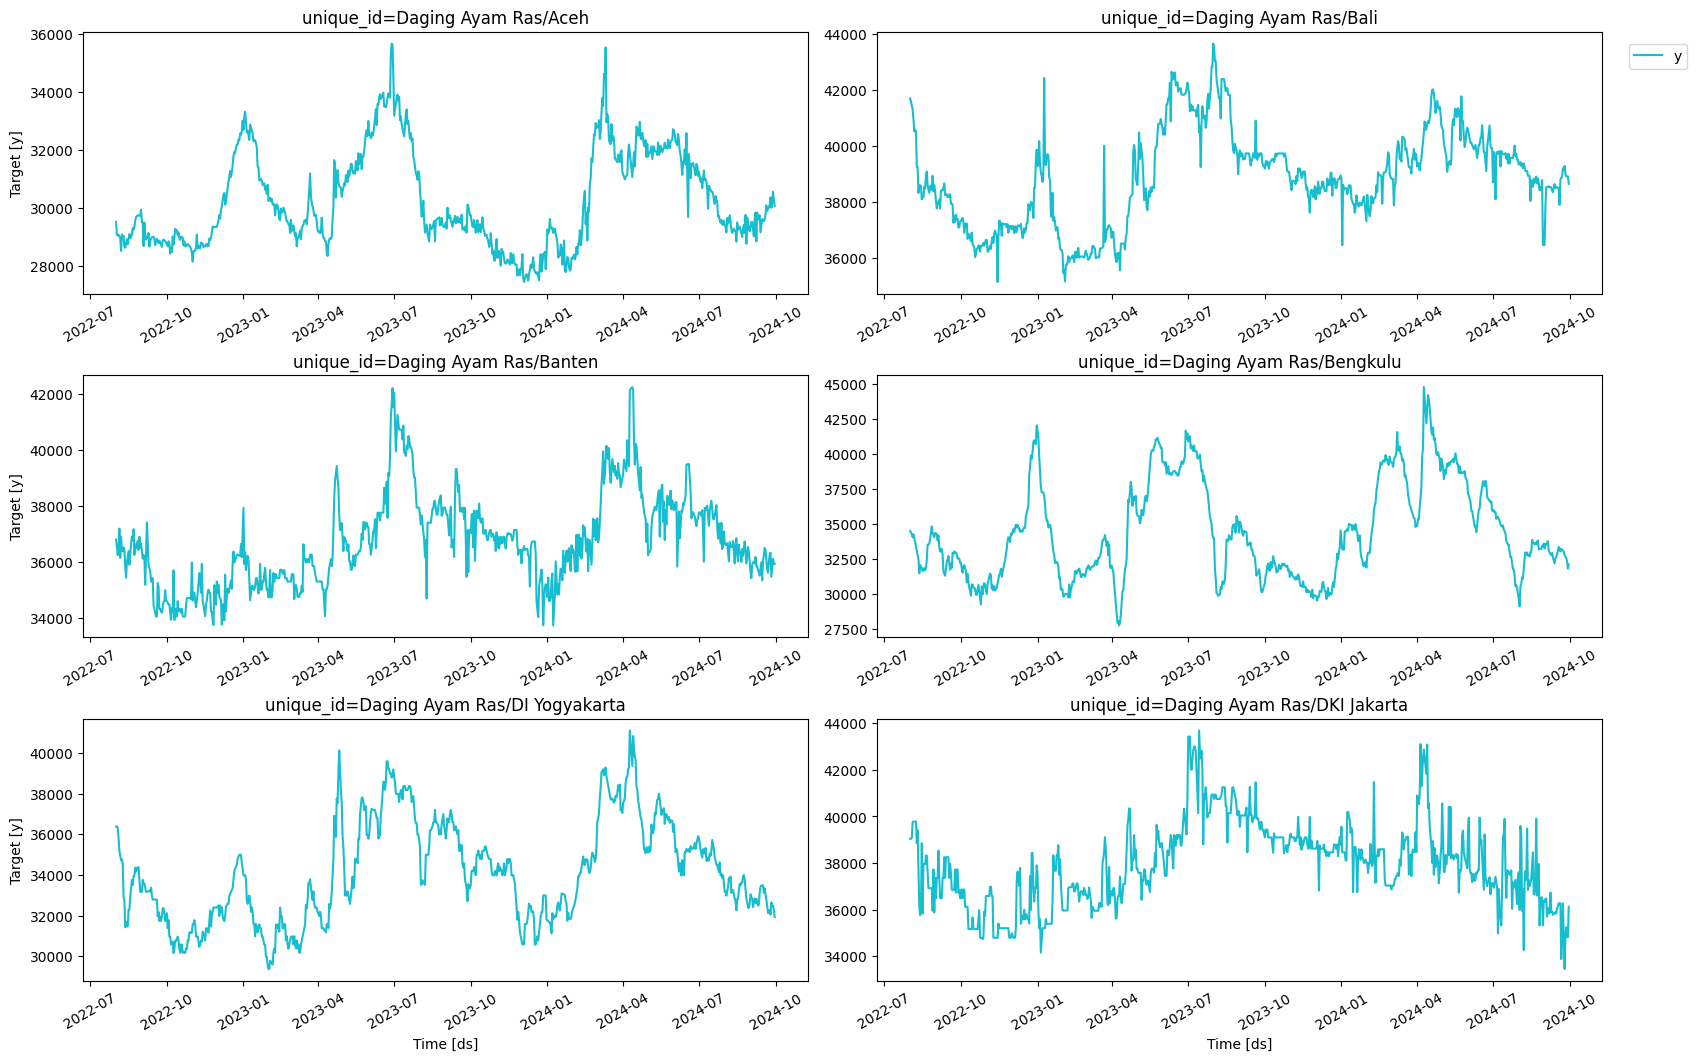

In [8]:
from utilsforecast.plotting import plot_series
uids = train_df['unique_id'].unique()[:6] # Select 10 ids to make the example faster
Y_df = train_df.query('unique_id in @uids').reset_index(drop=True)
plot_series(Y_df)


## Cross Validation

In [9]:
train_df['unique_id'].nunique()

442

In [8]:
from utilsforecast.losses import mse, mae, rmse, mape
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import PatchTST, NHITS, LSTM, RMoK, iTransformer, NBEATSx,TimesNet
from neuralforecast import NeuralForecast

itrans=iTransformer(
    h=92,                  # Forecast horizon
    n_series=442,
    input_size=180,        # Lookback window (6 months)
    scaler_type='revin',  # Robust scaling for outliers
    learning_rate=1e-3,
    max_steps=500,
    dropout=0.2,
    val_check_steps=50

)

rmok = RMoK(
    h=92,                  # Forecast horizon
    input_size=180,        # Lookback window (6 months
    revin_affine=True,
    n_series=442,
    scaler_type='revin',  # Robust scaling for outliers
    learning_rate=1e-3,
    max_steps=500,
    dropout=0.2,
    val_check_steps=50

)

timesnet = TimesNet(
    h=92,                  # Forecast horizon
    input_size=180,        # Lookback window (6 months)
    scaler_type='revin',  # Robust scaling for outliers
    futr_exog_list = ['is_holiday', 'prev_day_holiday', 'next_day_holiday'],
    learning_rate=1e-3,
    max_steps=100,
    dropout=0.2,
    val_check_steps=50

)
nbeats = NBEATSx(
    h=92,                  # Forecast horizon
    input_size=180,        # Lookback window (6 months)
    scaler_type='revin',  # Robust scaling for outliers
    futr_exog_list = ['is_holiday', 'prev_day_holiday', 'next_day_holiday'],
 #   stat_exog_list=['encoded_pangan', 'encoded_provinsi'],
    learning_rate=1e-3,
    max_steps=10,
    dropout_prob_theta=0.2,
    val_check_steps=50,
    random_seed=42,
)

nhits = NHITS(
    h=92,                  # Forecast horizon
    input_size=180,        # Lookback window (6 months)
    futr_exog_list = ['is_holiday', 'prev_day_holiday', 'next_day_holiday'],
    scaler_type='robust',  # Robust scaling for outliers
    learning_rate=1e-3,
    max_steps=500,
    dropout_prob_theta=0.2,
    val_check_steps=50

)

patch = PatchTST(
    h=92,                  # Forecast horizon
    input_size=180,        # Lookback window (6 months)
    patch_len=16,          # Patch length
    stride=8,              # Patch stride
    revin=True,            # RevIN normalization
    hidden_size=128,       # Model dimension
    n_heads=4,             # Number of attention heads
    scaler_type='robust',  # Robust scaling for outliers
    learning_rate=1e-3,
    dropout=0.2,
    max_steps=500,
    val_check_steps=50,

)

# Initialize NeuralForecast
nf = NeuralForecast(models=[timesnet,itrans,rmok, nhits, patch], freq='D')



In [24]:
cv_df = nf.cross_validation(train_df, n_windows=3, step_size=30)
cv_df.columns = cv_df.columns.str.replace('-median', '')
cv_df


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds     cutoff  \
0                          Bawang Merah/Aceh 2024-04-26 2024-04-25   
1                          Bawang Merah/Aceh 2024-04-27 2024-04-25   
2                          Bawang Merah/Aceh 2024-04-28 2024-04-25   
3                          Bawang Merah/Aceh 2024-04-29 2024-04-25   
4                          Bawang Merah/Aceh 2024-04-30 2024-04-25   
...                                      ...        ...        ...   
121987  Tepung Terigu (Curah)/Sumatera Utara 2024-09-26 2024-06-30   
121988  Tepung Terigu (Curah)/Sumatera Utara 2024-09-27 2024-06-30   
121989  Tepung Terigu (Curah)/Sumatera Utara 2024-09-28 2024-06-30   
121990  Tepung Terigu (Curah)/Sumatera Utara 2024-09-29 2024-06-30   
121991  Tepung Terigu (Curah)/Sumatera Utara 2024-09-30 2024-06-30   

            TimesNet  iTransformer          RMoK         NHITS      PatchTST  \
0       54467.968750  68232.968750  49752.917969  60192.710938  60350.906250   
1       54863.640625  68377.007812  49814.027344  60265.507812  60334.500000   
2       55140.500000  68989.796875  48992.949219  60249.562500  60354.667969   
3       55217.203125  68415.976562  49524.132812  60267.492188  60345.660156   
4       54589.820312  68661.468750  49100.558594  60197.351562  60332.585938   
...              ...           ...           ...           ...           ...   
121987  10805.149414  10791.781250  10902.470703  10649.670898  10712.588867   
121988  10801.142578  10803.212891  10903.854492  10650.183594  10712.665039   
121989  10806.659180  10812.741211  10912.072266  10648.552734  10711.522461   
121990  10805.783203  10797.239258  10911.680664  10648.041016  10711.225586   
121991  10804.025391  10794.789062  10852.317383  10648.001953  10711.268555   

              y  
0       60650.0  
1       60550.0  
2       60200.0  
3       59660.0  
4       58520.0  
...         ...  
121987  10710.0  
121988  10570.0  
121989  10670.0  
121990  10710.0  
121991  10640.0  

[121992 rows x 9 columns]

In [34]:
cv_df[cv_df['unique_id']=='Bawang Merah/Aceh']['cutoff'].unique()

<DatetimeArray>
['2024-04-25 00:00:00', '2024-05-26 00:00:00', '2024-06-26 00:00:00']
Length: 3, dtype: datetime64[ns]

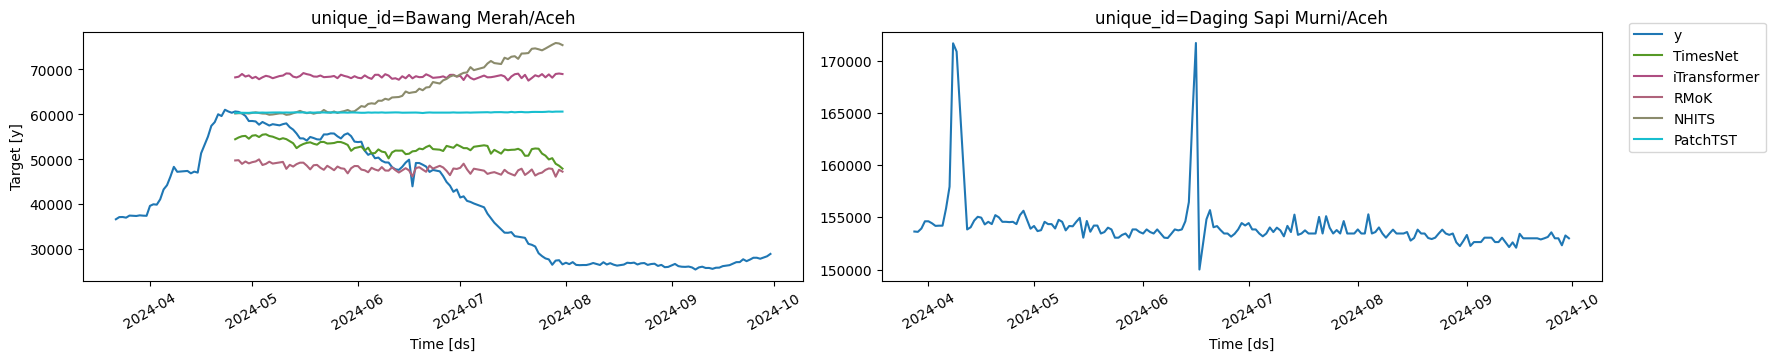

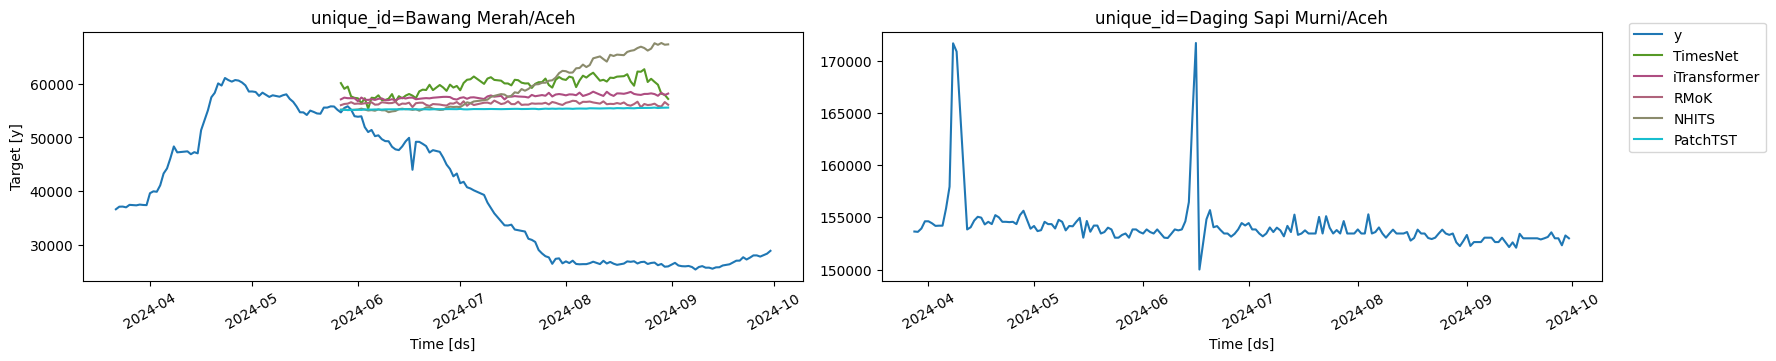

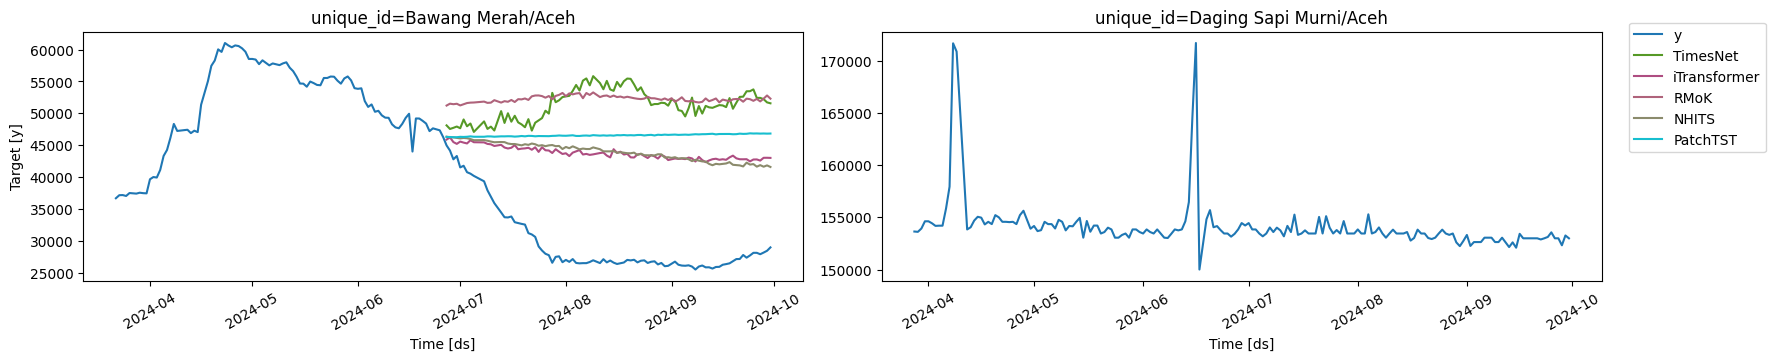

In [38]:
from IPython.display import display

from utilsforecast.plotting import plot_series

for cutoff in cv_df[cv_df['unique_id']=='Bawang Merah/Aceh']['cutoff'].unique():
    display(
        plot_series(
            train_df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=92*2, 
            ids=['Bawang Merah/Aceh'],
        )
    )

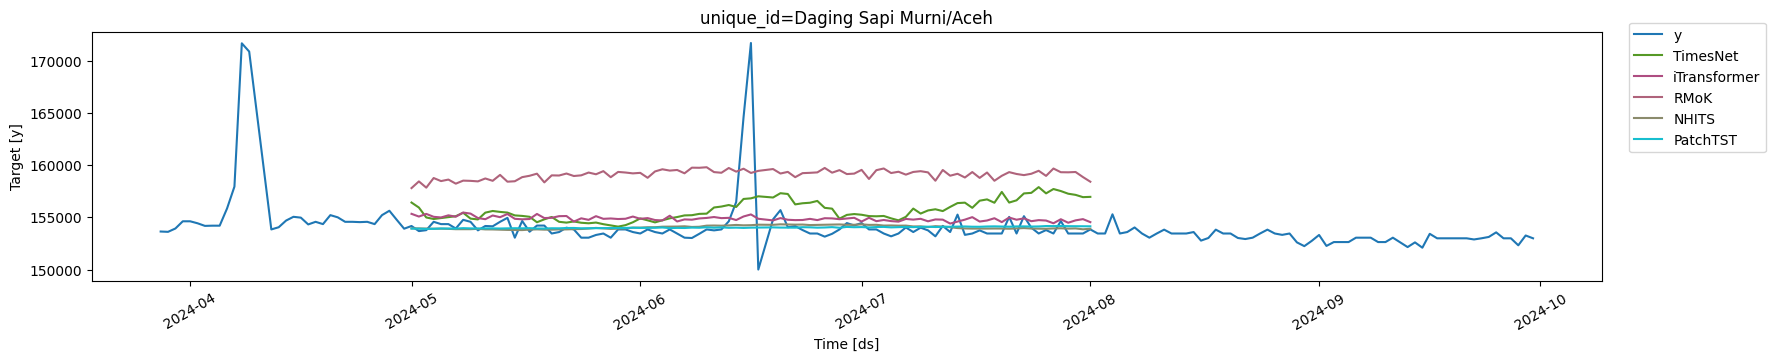

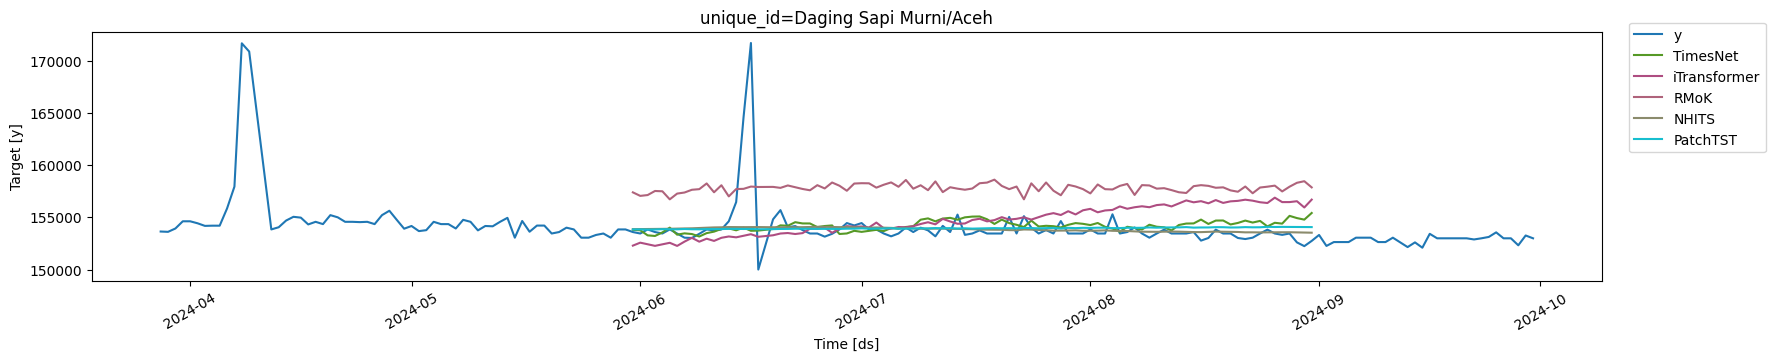

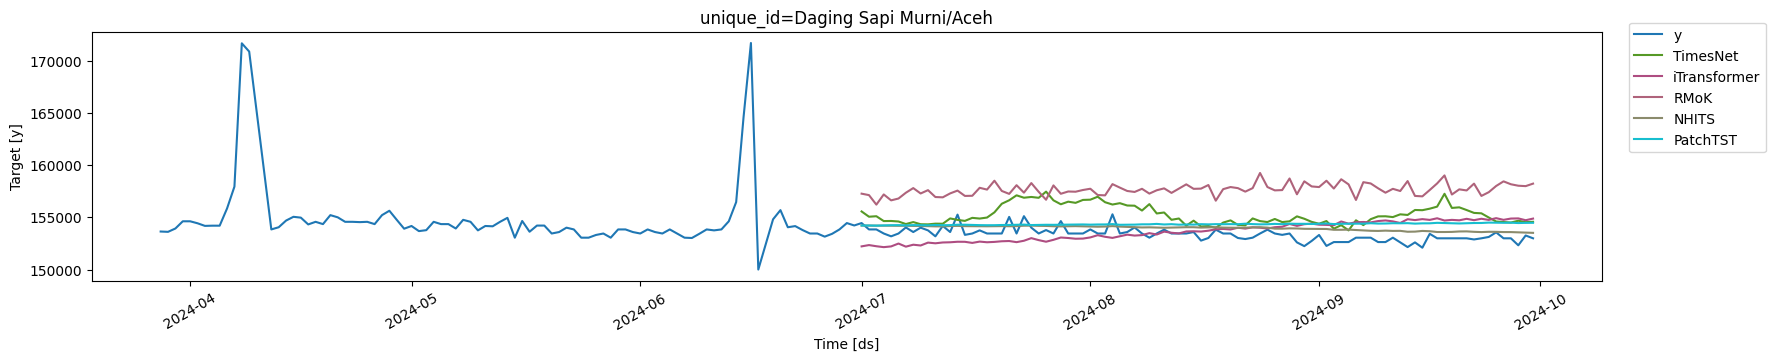

In [39]:
from IPython.display import display

from utilsforecast.plotting import plot_series

for cutoff in cv_df[cv_df['unique_id']=='Daging Sapi Murni/Aceh']['cutoff'].unique():
    display(
        plot_series(
            train_df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=92*2, 
            ids=['Daging Sapi Murni/Aceh'],
        )
    )

In [26]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mape])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df[:34]

unique_id metric  TimesNet  iTransformer  \
0                        Bawang Merah/Aceh   mape  0.582153      0.577864   
1                        Bawang Merah/Bali   mape  0.510078      0.568846   
2                      Bawang Merah/Banten   mape  0.537309      0.439030   
3                    Bawang Merah/Bengkulu   mape  0.573970      0.568727   
4               Bawang Merah/DI Yogyakarta   mape  0.665953      0.621243   
5                 Bawang Merah/DKI Jakarta   mape  0.501836      0.399139   
6                   Bawang Merah/Gorontalo   mape  0.437531      0.292837   
7                       Bawang Merah/Jambi   mape  0.535359      0.442813   
8                  Bawang Merah/Jawa Barat   mape  0.492520      0.450404   
9                 Bawang Merah/Jawa Tengah   mape  0.631720      0.534174   
10                 Bawang Merah/Jawa Timur   mape  0.671864      0.694042   
11           Bawang Merah/Kalimantan Barat   mape  0.265127      0.244818   
12         Bawang Merah/Kalimantan Selatan   mape  0.467347      0.474059   
13          Bawang Merah/Kalimantan Tengah   mape  0.371335      0.408688   
14           Bawang Merah/Kalimantan Timur   mape  0.304584      0.275094   
15           Bawang Merah/Kalimantan Utara   mape  0.264524      0.309476   
16  Bawang Merah/Kepulauan Bangka Belitung   mape  0.586212      0.511251   
17             Bawang Merah/Kepulauan Riau   mape  0.077937      0.082211   
18                    Bawang Merah/Lampung   mape  0.726707      0.648908   
19                     Bawang Merah/Maluku   mape  0.222682      0.227163   
20               Bawang Merah/Maluku Utara   mape  0.137885      0.201660   
21        Bawang Merah/Nusa Tenggara Barat   mape  0.622204      0.605646   
22        Bawang Merah/Nusa Tenggara Timur   mape  0.496629      0.407009   
23                      Bawang Merah/Papua   mape  0.160087      0.185824   
24                Bawang Merah/Papua Barat   mape  0.070388      0.087595   
25                       Bawang Merah/Riau   mape  0.442576      0.420659   
26             Bawang Merah/Sulawesi Barat   mape  0.393704      0.338117   
27           Bawang Merah/Sulawesi Selatan   mape  0.379937      0.387171   
28            Bawang Merah/Sulawesi Tengah   mape  0.332835      0.330777   
29          Bawang Merah/Sulawesi Tenggara   mape  0.344276      0.369994   
30             Bawang Merah/Sulawesi Utara   mape  0.324298      0.268344   
31             Bawang Merah/Sumatera Barat   mape  0.557158      0.481972   
32           Bawang Merah/Sumatera Selatan   mape  0.643343      0.540756   
33             Bawang Merah/Sumatera Utara   mape  0.489583      0.441563   

        RMoK     NHITS  PatchTST    best_model  
0   0.550918  0.595792  0.528962      PatchTST  
1   0.498583  0.333804  0.454797         NHITS  
2   0.561063  0.307097  0.427721         NHITS  
3   0.580495  0.561171  0.528728      PatchTST  
4   0.673289  0.492138  0.625299         NHITS  
5   0.488462  0.311768  0.444515         NHITS  
6   0.398506  0.153979  0.334975         NHITS  
7   0.508553  0.441726  0.454558         NHITS  
8   0.501516  0.278289  0.439608         NHITS  
9   0.620758  0.482016  0.497586         NHITS  
10  0.667142  0.512169  0.592587         NHITS  
11  0.250739  0.184057  0.229234         NHITS  
12  0.433138  0.276987  0.480754         NHITS  
13  0.372153  0.298436  0.366255         NHITS  
14  0.277875  0.180833  0.286602         NHITS  
15  0.267258  0.122661  0.247458         NHITS  
16  0.585412  0.369408  0.507218         NHITS  
17  0.076769  0.077384  0.091200          RMoK  
18  0.716394  0.509666  0.636423         NHITS  
19  0.215151  0.277270  0.212838      PatchTST  
20  0.126309  0.209122  0.149563          RMoK  
21  0.574144  0.839493  0.579068          RMoK  
22  0.491280  0.633476  0.449236  iTransformer  
23  0.154280  0.041378  0.153550         NHITS  
24  0.065895  0.066883  0.064531      PatchTST  
25  0.428337  0.391260  0.377358      PatchTST  
26  0.359107  

In [27]:
evaluation_df['best_model_mape'] = evaluation_df.apply(lambda row: row[row['best_model']], axis=1)
evaluation_df.sort_values('best_model_mape', ascending=False)[:40]

unique_id metric  TimesNet  \
21              Bawang Merah/Nusa Tenggara Barat   mape  0.622204   
0                              Bawang Merah/Aceh   mape  0.582153   
3                          Bawang Merah/Bengkulu   mape  0.573970   
32                 Bawang Merah/Sumatera Selatan   mape  0.643343   
10                       Bawang Merah/Jawa Timur   mape  0.671864   
18                          Bawang Merah/Lampung   mape  0.726707   
4                     Bawang Merah/DI Yogyakarta   mape  0.665953   
9                       Bawang Merah/Jawa Tengah   mape  0.631720   
31                   Bawang Merah/Sumatera Barat   mape  0.557158   
7                             Bawang Merah/Jambi   mape  0.535359   
33                   Bawang Merah/Sumatera Utara   mape  0.489583   
22              Bawang Merah/Nusa Tenggara Timur   mape  0.496629   
25                             Bawang Merah/Riau   mape  0.442576   
16        Bawang Merah/Kepulauan Bangka Belitung   mape  0.586212   
1                              Bawang Merah/Bali   mape  0.510078   
29                Bawang Merah/Sulawesi Tenggara   mape  0.344276   
5                       Bawang Merah/DKI Jakarta   mape  0.501836   
2                            Bawang Merah/Banten   mape  0.537309   
13                Bawang Merah/Kalimantan Tengah   mape  0.371335   
180                 Cabai Rawit Merah/Jawa Timur   mape  0.316202   
8                        Bawang Merah/Jawa Barat   mape  0.492520   
171                       Cabai Rawit Merah/Bali   mape  0.318327   
12               Bawang Merah/Kalimantan Selatan   mape  0.467347   
174              Cabai Rawit Merah/DI Yogyakarta   mape  0.317956   
30                   Bawang Merah/Sulawesi Utara   mape  0.324298   
172                     Cabai Rawit Merah/Banten   mape  0.249420   
179                Cabai Rawit Merah/Jawa Tengah   mape  0.300891   
191        Cabai Rawit Merah/Nusa Tenggara Barat   mape  0.251959   
178                 Cabai Rawit Merah/Jawa Barat   mape  0.255136   
19                           Bawang Merah/Maluku   mape  0.222682   
140           Cabai Merah Keriting/DI Yogyakarta   mape  0.362505   
145             Cabai Merah Keriting/Jawa Tengah   mape  0.347021   
146              Cabai Merah Keriting/Jawa Timur   mape  0.338449   
136                    Cabai Merah Keriting/Aceh   mape  0.331995   
175                Cabai Rawit Merah/DKI Jakarta   mape  0.270198   
28                  Bawang Merah/Sulawesi Tengah   mape  0.332835   
11                 Bawang Merah/Kalimantan Barat   mape  0.265127   
186  Cabai Rawit Merah/Kepulauan Bangka Belitung   mape  0.225720   
139                Cabai Merah Keriting/Bengkulu   mape  0.382611   
14                 Bawang Merah/Kalimantan Timur   mape  0.304584   

     iTransformer      RMoK     NHITS  PatchTST    best_model  best_model_mape  
21       0.605646  0.574144  0.839493  0.579068          RMoK         0.574144  
0        0.577864  0.550918  0.595792  0.528962      PatchTST         0.528962  
3        0.568727  0.580495  0.561171  0.528728      PatchTST         0.528728  
32       0.540756  0.635501  0.518403  0.568499         NHITS         0.518403  
10       0.694042  0.667142  0.512169  0.592587         NHITS         0.512169  
18       0.648908  0.716394  0.509666  0.636423         NHITS         0.509666  
4        0.621243  0.673289  0.492138  0.625299         NHITS         0.492138  
9        0.534174  0.620758  0.482016  0.497586         NHITS         0.482016  
31       0.481972  0.523670  0.470537  0.483996         NHITS         0.470537  
7        0.442813  0.508553  0.441726  0.454558         NHITS         0.441726  
33       0.441563  0.487226  0.428157  0.421425      PatchTST         0.421425  
22       0.407009  0.491280  0.633476  0.449236  iTransformer         0.407009  
25       0.420659  0.428337  0.391260  0.377358      PatchTST         0.377358  
16       0.511251  0.585412  0.369408  0.507218         NHITS         0.369

In [28]:
evaluation_df.sort_values('best_model_mape', ascending=False)[40:80]

unique_id metric  TimesNet  iTransformer  \
176               Cabai Rawit Merah/Gorontalo   mape  0.375937      0.751131   
182      Cabai Rawit Merah/Kalimantan Selatan   mape  0.189927      0.315958   
202        Cabai Rawit Merah/Sumatera Selatan   mape  0.230665      0.208357   
148   Cabai Merah Keriting/Kalimantan Selatan   mape  0.391621      0.445554   
200          Cabai Rawit Merah/Sulawesi Utara   mape  0.375481      0.709554   
143                Cabai Merah Keriting/Jambi   mape  0.365704      0.399716   
167       Cabai Merah Keriting/Sumatera Barat   mape  0.403941      0.407873   
177                   Cabai Rawit Merah/Jambi   mape  0.177960      0.205146   
159                Cabai Merah Keriting/Papua   mape  0.207780      0.329303   
157  Cabai Merah Keriting/Nusa Tenggara Barat   mape  0.303516      0.251934   
137                 Cabai Merah Keriting/Bali   mape  0.334462      0.305740   
161                 Cabai Merah Keriting/Riau   mape  0.294450      0.323578   
160          Cabai Merah Keriting/Papua Barat   mape  0.158167      0.175713   
6                      Bawang Merah/Gorontalo   mape  0.437531      0.292837   
151     Cabai Merah Keriting/Kalimantan Utara   mape  0.189010      0.168503   
169       Cabai Merah Keriting/Sumatera Utara   mape  0.352394      0.368226   
154              Cabai Merah Keriting/Lampung   mape  0.318624      0.318089   
138               Cabai Merah Keriting/Banten   mape  0.313695      0.236893   
188                 Cabai Rawit Merah/Lampung   mape  0.155300      0.147672   
166       Cabai Merah Keriting/Sulawesi Utara   mape  0.139561      0.328977   
197        Cabai Rawit Merah/Sulawesi Selatan   mape  0.247422      0.673087   
168     Cabai Merah Keriting/Sumatera Selatan   mape  0.296699      0.330001   
183       Cabai Rawit Merah/Kalimantan Tengah   mape  0.181668      0.241254   
184        Cabai Rawit Merah/Kalimantan Timur   mape  0.182996      0.274284   
192     Cabai Rawit Merah/Nusa Tenggara Timur   mape  0.214638      0.210137   
194             Cabai Rawit Merah/Papua Barat   mape  0.162385      0.146179   
207                  Daging Ayam Ras/Bengkulu   mape  0.129885      0.167361   
150     Cabai Merah Keriting/Kalimantan Timur   mape  0.264297      0.268626   
27              Bawang Merah/Sulawesi Selatan   mape  0.379937      0.387171   
20                  Bawang Merah/Maluku Utara   mape  0.137885      0.201660   
170                    Cabai Rawit Merah/Aceh   mape  0.151943      0.375932   
15              Bawang Merah/Kalimantan Utara   mape  0.264524      0.309476   
142            Cabai Merah Keriting/Gorontalo   mape  0.207781      0.394075   
189                  Cabai Rawit Merah/Maluku   mape  0.158954      0.416035   
155               Cabai Merah Keriting/Maluku   mape  0.121923      0.118196   
229                      Daging Ayam Ras/Riau   mape  0.141205      0.116342   
26                Bawang Merah/Sulawesi Barat   mape  0.393704      0.338117   
164      Cabai Merah Keriting/Sulawesi Tengah   mape  0.182358      0.200844   
162       Cabai Merah Keriting/Sulawesi Barat   mape  0.196349      0.206148   
199       Cabai Rawit Merah/Sulawesi Tenggara   mape  0.219747      0.505532   

         RMoK     NHITS  PatchTST    best_model  best_model_mape  
176  0.428110  0.335950  0.178402      PatchTST         0.178402  
182  0.234859  0.207802  0.177296      PatchTST         0.177296  
202  0.224296  0.202962  0.170569      PatchTST         0.170569  
148  0.434242  0.169211  0.215010         NHITS         0.169211  
200  0.494134  0.317496  0.167035      PatchTST         0.167035  
143  0.420027  0.166583  0.239771         NHITS         0.166583  
167  0.439412  0.166538  0.210975         NHITS         0.166538  
177  0.203264  0.175263  0.163944      PatchTST         0.163944  
159  0.165348  0.163866  0.195143         NHITS         0.163866  
157  0.212639  0.162623  0.170255         NHITS         0.162623  
137  0.371265  0.1

In [29]:
evaluation_df.sort_values('best_model_mape', ascending=True)[:40]

unique_id metric  TimesNet  \
253                 Daging Sapi Murni/Kalimantan Utara   mape  0.010238   
249                 Daging Sapi Murni/Kalimantan Barat   mape  0.005291   
424    Tepung Terigu (Curah)/Kepulauan Bangka Belitung   mape  0.010914   
265                 Daging Sapi Murni/Sulawesi Selatan   mape  0.005670   
269                   Daging Sapi Murni/Sumatera Barat   mape  0.005712   
248                       Daging Sapi Murni/Jawa Timur   mape  0.011165   
372   Minyak Goreng Kemasan Sederhana/Sumatera Selatan   mape  0.008079   
348         Minyak Goreng Kemasan Sederhana/Jawa Barat   mape  0.004151   
338               Minyak Goreng Curah/Sumatera Selatan   mape  0.009175   
268                   Daging Sapi Murni/Sulawesi Utara   mape  0.004389   
245                            Daging Sapi Murni/Jambi   mape  0.010456   
267                Daging Sapi Murni/Sulawesi Tenggara   mape  0.008795   
259              Daging Sapi Murni/Nusa Tenggara Barat   mape  0.005206   
264                   Daging Sapi Murni/Sulawesi Barat   mape  0.004854   
133                       Beras Premium/Sumatera Barat   mape  0.008152   
101                        Beras Medium/Sumatera Utara   mape  0.005613   
122                         Beras Premium/Maluku Utara   mape  0.010162   
371     Minyak Goreng Kemasan Sederhana/Sumatera Barat   mape  0.006629   
238                             Daging Sapi Murni/Aceh   mape  0.010946   
113                     Beras Premium/Kalimantan Barat   mape  0.013858   
263                             Daging Sapi Murni/Riau   mape  0.019592   
135                       Beras Premium/Sumatera Utara   mape  0.008021   
102                                 Beras Premium/Aceh   mape  0.005907   
426                      Tepung Terigu (Curah)/Lampung   mape  0.008403   
251                Daging Sapi Murni/Kalimantan Tengah   mape  0.008336   
242                    Daging Sapi Murni/DI Yogyakarta   mape  0.010906   
271                   Daging Sapi Murni/Sumatera Utara   mape  0.011916   
241                         Daging Sapi Murni/Bengkulu   mape  0.015601   
358            Minyak Goreng Kemasan Sederhana/Lampung   mape  0.006133   
407                      Telur Ayam Ras/Sumatera Utara   mape  0.010604   
95                       Beras Medium/Sulawesi Selatan   mape  0.015698   
261                            Daging Sapi Murni/Papua   mape  0.014040   
349        Minyak Goreng Kemasan Sederhana/Jawa Tengah   mape  0.014412   
270                 Daging Sapi Murni/Sumatera Selatan   mape  0.012657   
244                        Daging Sapi Murni/Gorontalo   mape  0.007303   
344      Minyak Goreng Kemasan Sederhana/DI Yogyakarta   mape  0.012238   
68                                   Beras Medium/Aceh   mape  0.007506   
85                         Beras Medium/Kepulauan Riau   mape  0.008176   
353  Minyak Goreng Kemasan Sederhana/Kalimantan Tengah   mape  0.010867   
365               Minyak Goreng Kemasan Sederhana/Riau   mape  0.007249   

     iTransformer      RMoK     NHITS  PatchTST    best_model  best_model_mape  
253      0.007731  0.004826  0.002745  0.002460      PatchTST         0.002460  
249      0.005698  0.006198  0.003934  0.002881      PatchTST         0.002881  
424      0.033450  0.004711  0.019002  0.003140      PatchTST         0.003140  
265      0.003677  0.006334  0.003326  0.003197      PatchTST         0.003197  
269      0.003306  0.008429  0.005361  0.003838  iTransformer         0.003306  
248      0.005600  0.014285  0.003946  0.003572      PatchTST         0.003572  
372      0.003886  0.005888  0.016803  0.005305  iTransformer         0.003886  
348      0.010585  0.005465  0.011058  0.006523      TimesNet         0.004151  
338      0.004222  0.006739  0.016534  0.004356  iTransformer         0.004222  
268      0.006509  0.004416  0.006900  0.006191      TimesNet         0.004389  
245      0.005554  0.014828  0.005138  0.004402      PatchTST         0.004402

In [30]:
evaluation_df[evaluation_df['unique_id']=='Bawang Merah/Kalimantan Utara']

unique_id metric  TimesNet  iTransformer      RMoK  \
15  Bawang Merah/Kalimantan Utara   mape  0.264524      0.309476  0.267258   

       NHITS  PatchTST best_model  best_model_mape  
15  0.122661  0.247458      NHITS         0.122661

In [31]:
evaluation_df.describe()

TimesNet  iTransformer        RMoK       NHITS    PatchTST  \
count  442.000000    442.000000  442.000000  442.000000  442.000000   
mean     0.096402      0.099526    0.095927    0.080774    0.075584   
std      0.136258      0.146775    0.136711    0.109544    0.113558   
min      0.004151      0.003306    0.004416    0.002745    0.002460   
25%      0.017142      0.017089    0.016718    0.018946    0.013708   
50%      0.037841      0.032057    0.035369    0.036889    0.028816   
75%      0.102453      0.089287    0.100698    0.091779    0.079557   
max      0.726707      0.751131    0.716394    0.839493    0.636423   

       best_model_mape  
count       442.000000  
mean          0.064655  
std           0.097611  
min           0.002460  
25%           0.011801  
50%           0.025636  
75%           0.068996  
max           0.574144

berdasarkan hasil cv, terlihat bahwa model nhits dan patchtst memiliki hasil terbaik, sehingga kami akan melakukan voting pada kedua model tersebut untuk memperoleh hasil akhir.

In [32]:
evaluation_df['best_model'].value_counts()

best_model
PatchTST        168
NHITS           100
iTransformer     91
RMoK             59
TimesNet         24
Name: count, dtype: int64

## CV For Final Model

In [9]:
# Initialize NeuralForecast
nf = NeuralForecast(models=[ nhits, patch], freq='D')
cv_df = nf.cross_validation(train_df, n_windows=3, step_size=30)
cv_df.columns = cv_df.columns.str.replace('-median', '')

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mape])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)


In [40]:
# Initialize NeuralForecast
nf = NeuralForecast(models=[ nhits, patch], freq='D')
cv_df = nf.cross_validation(train_df, n_windows=3, step_size=30)
cv_df.columns = cv_df.columns.str.replace('-median', '')
cv_df


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds     cutoff  \
0                          Bawang Merah/Aceh 2024-04-26 2024-04-25   
1                          Bawang Merah/Aceh 2024-04-27 2024-04-25   
2                          Bawang Merah/Aceh 2024-04-28 2024-04-25   
3                          Bawang Merah/Aceh 2024-04-29 2024-04-25   
4                          Bawang Merah/Aceh 2024-04-30 2024-04-25   
...                                      ...        ...        ...   
121987  Tepung Terigu (Curah)/Sumatera Utara 2024-09-26 2024-06-30   
121988  Tepung Terigu (Curah)/Sumatera Utara 2024-09-27 2024-06-30   
121989  Tepung Terigu (Curah)/Sumatera Utara 2024-09-28 2024-06-30   
121990  Tepung Terigu (Curah)/Sumatera Utara 2024-09-29 2024-06-30   
121991  Tepung Terigu (Curah)/Sumatera Utara 2024-09-30 2024-06-30   

               NHITS      PatchTST        y  
0       60305.042969  60350.906250  60650.0  
1       60308.125000  60334.500000  60550.0  
2       60443.304688  60354.667969  60200.0  
3       60471.414062  60345.660156  59660.0  
4       60328.960938  60332.585938  58520.0  
...              ...           ...      ...  
121987  10640.504883  10712.588867  10710.0  
121988  10640.964844  10712.665039  10570.0  
121989  10640.140625  10711.522461  10670.0  
121990  10640.538086  10711.225586  10710.0  
121991  10640.950195  10711.268555  10640.0  

[121992 rows x 6 columns]

In [41]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mape])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df[:34]

unique_id metric     NHITS  PatchTST  \
0                        Bawang Merah/Aceh   mape  0.579521  0.528962   
1                        Bawang Merah/Bali   mape  0.420157  0.454797   
2                      Bawang Merah/Banten   mape  0.339512  0.427721   
3                    Bawang Merah/Bengkulu   mape  0.589784  0.528728   
4               Bawang Merah/DI Yogyakarta   mape  0.486962  0.625299   
5                 Bawang Merah/DKI Jakarta   mape  0.328977  0.444515   
6                   Bawang Merah/Gorontalo   mape  0.195035  0.334975   
7                       Bawang Merah/Jambi   mape  0.500320  0.454558   
8                  Bawang Merah/Jawa Barat   mape  0.302049  0.439608   
9                 Bawang Merah/Jawa Tengah   mape  0.437882  0.497586   
10                 Bawang Merah/Jawa Timur   mape  0.581351  0.592587   
11           Bawang Merah/Kalimantan Barat   mape  0.281589  0.229234   
12         Bawang Merah/Kalimantan Selatan   mape  0.247735  0.480754   
13          Bawang Merah/Kalimantan Tengah   mape  0.341950  0.366255   
14           Bawang Merah/Kalimantan Timur   mape  0.202466  0.286602   
15           Bawang Merah/Kalimantan Utara   mape  0.181770  0.247458   
16  Bawang Merah/Kepulauan Bangka Belitung   mape  0.383499  0.507218   
17             Bawang Merah/Kepulauan Riau   mape  0.072279  0.091200   
18                    Bawang Merah/Lampung   mape  0.565386  0.636423   
19                     Bawang Merah/Maluku   mape  0.255324  0.212838   
20               Bawang Merah/Maluku Utara   mape  0.199327  0.149563   
21        Bawang Merah/Nusa Tenggara Barat   mape  0.821600  0.579068   
22        Bawang Merah/Nusa Tenggara Timur   mape  0.599406  0.449236   
23                      Bawang Merah/Papua   mape  0.055183  0.153550   
24                Bawang Merah/Papua Barat   mape  0.063261  0.064531   
25                       Bawang Merah/Riau   mape  0.486639  0.377358   
26             Bawang Merah/Sulawesi Barat   mape  0.195264  0.356230   
27           Bawang Merah/Sulawesi Selatan   mape  0.199851  0.348830   
28            Bawang Merah/Sulawesi Tengah   mape  0.237150  0.313907   
29          Bawang Merah/Sulawesi Tenggara   mape  0.415124  0.312605   
30             Bawang Merah/Sulawesi Utara   mape  0.178515  0.271099   
31             Bawang Merah/Sumatera Barat   mape  0.490179  0.483996   
32           Bawang Merah/Sumatera Selatan   mape  0.641308  0.568499   
33             Bawang Merah/Sumatera Utara   mape  0.517100  0.421425   

   best_model  
0    PatchTST  
1       NHITS  
2       NHITS  
3    PatchTST  
4       NHITS  
5       NHITS  
6       NHITS  
7    PatchTST  
8       NHITS  
9       NHITS  
10      NHITS  
11   PatchTST  
12      NHITS  
13      NHITS  
14      NHITS  
15      NHITS  
16      NHITS  
17      NHITS  
18      NHITS  
19   PatchTST  
20   PatchTST  
21   PatchTST  
22   PatchTST  
23      NHITS  
24      NHITS  
25   PatchTST  
26      NHITS  
27      NHITS  
28      NHITS  
29   PatchTST  
30      NHITS  
31   PatchTST  
32   PatchTST  
33   PatchTST

In [44]:
evaluation_df['best_model_mape'] = evaluation_df.apply(lambda row: row[row['best_model']], axis=1)
evaluation_df.sort_values('best_model_mape', ascending=False)[:40]

unique_id metric     NHITS  PatchTST  \
10                  Bawang Merah/Jawa Timur   mape  0.581351  0.592587   
21         Bawang Merah/Nusa Tenggara Barat   mape  0.821600  0.579068   
32            Bawang Merah/Sumatera Selatan   mape  0.641308  0.568499   
18                     Bawang Merah/Lampung   mape  0.565386  0.636423   
0                         Bawang Merah/Aceh   mape  0.579521  0.528962   
3                     Bawang Merah/Bengkulu   mape  0.589784  0.528728   
4                Bawang Merah/DI Yogyakarta   mape  0.486962  0.625299   
31              Bawang Merah/Sumatera Barat   mape  0.490179  0.483996   
7                        Bawang Merah/Jambi   mape  0.500320  0.454558   
22         Bawang Merah/Nusa Tenggara Timur   mape  0.599406  0.449236   
9                  Bawang Merah/Jawa Tengah   mape  0.437882  0.497586   
33              Bawang Merah/Sumatera Utara   mape  0.517100  0.421425   
1                         Bawang Merah/Bali   mape  0.420157  0.454797   
16   Bawang Merah/Kepulauan Bangka Belitung   mape  0.383499  0.507218   
25                        Bawang Merah/Riau   mape  0.486639  0.377358   
13           Bawang Merah/Kalimantan Tengah   mape  0.341950  0.366255   
2                       Bawang Merah/Banten   mape  0.339512  0.427721   
5                  Bawang Merah/DKI Jakarta   mape  0.328977  0.444515   
29           Bawang Merah/Sulawesi Tenggara   mape  0.415124  0.312605   
8                   Bawang Merah/Jawa Barat   mape  0.302049  0.439608   
180            Cabai Rawit Merah/Jawa Timur   mape  0.315034  0.293367   
171                  Cabai Rawit Merah/Bali   mape  0.296155  0.278111   
12          Bawang Merah/Kalimantan Selatan   mape  0.247735  0.480754   
174         Cabai Rawit Merah/DI Yogyakarta   mape  0.264977  0.241633   
28             Bawang Merah/Sulawesi Tengah   mape  0.237150  0.313907   
172                Cabai Rawit Merah/Banten   mape  0.253314  0.229345   
11            Bawang Merah/Kalimantan Barat   mape  0.281589  0.229234   
179           Cabai Rawit Merah/Jawa Tengah   mape  0.259373  0.229098   
191   Cabai Rawit Merah/Nusa Tenggara Barat   mape  0.226428  0.221710   
143              Cabai Merah Keriting/Jambi   mape  0.218938  0.239771   
178            Cabai Rawit Merah/Jawa Barat   mape  0.228890  0.217127   
19                      Bawang Merah/Maluku   mape  0.255324  0.212838   
167     Cabai Merah Keriting/Sumatera Barat   mape  0.211009  0.210975   
140      Cabai Merah Keriting/DI Yogyakarta   mape  0.209040  0.217027   
136               Cabai Merah Keriting/Aceh   mape  0.245720  0.208655   
166     Cabai Merah Keriting/Sulawesi Utara   mape  0.217127  0.203330   
14            Bawang Merah/Kalimantan Timur   mape  0.202466  0.286602   
146         Cabai Merah Keriting/Jawa Timur   mape  0.205200  0.201240   
139           Cabai Merah Keriting/Bengkulu   mape  0.202489  0.200211   
27            Bawang Merah/Sulawesi Selatan   mape  0.199851  0.348830   

    best_model  best_model_mape  
10       NHITS         0.581351  
21    PatchTST         0.579068  
32    PatchTST         0.568499  
18       NHITS         0.565386  
0     PatchTST         0.528962  
3     PatchTST         0.528728  
4        NHITS         0.486962  
31    PatchTST         0.483996  
7     PatchTST         0.454558  
22    PatchTST         0.449236  
9        NHITS         0.437882  
33    PatchTST         0.421425  
1        NHITS         0.420157  
16       NHITS         0.383499  
25    PatchTST         0.377358  
13       NHITS         0.341950  
2        NHITS         0.339512  
5        NHITS         0.328977  
29    PatchTST         0.312605  
8        NHITS         0.302049  
180   PatchTST         0.293367  
171   PatchTST         0.278111  
12       NHITS         0.247735  
174   PatchTST         0.241633  
28       NHITS         0.237150  
172   PatchTST         0.229345  
11    PatchTST         0.229234  
179   PatchTST         0.229098  
191   PatchTS

In [45]:
evaluation_df.sort_values('best_model_mape', ascending=True)[:40]

unique_id metric     NHITS  \
253                Daging Sapi Murni/Kalimantan Utara   mape  0.003933   
249                Daging Sapi Murni/Kalimantan Barat   mape  0.004278   
424   Tepung Terigu (Curah)/Kepulauan Bangka Belitung   mape  0.016393   
265                Daging Sapi Murni/Sulawesi Selatan   mape  0.003393   
248                      Daging Sapi Murni/Jawa Timur   mape  0.004172   
269                  Daging Sapi Murni/Sumatera Barat   mape  0.005228   
338              Minyak Goreng Curah/Sumatera Selatan   mape  0.010733   
245                           Daging Sapi Murni/Jambi   mape  0.004704   
267               Daging Sapi Murni/Sulawesi Tenggara   mape  0.004424   
135                      Beras Premium/Sumatera Utara   mape  0.004448   
259             Daging Sapi Murni/Nusa Tenggara Barat   mape  0.005228   
113                    Beras Premium/Kalimantan Barat   mape  0.008051   
271                  Daging Sapi Murni/Sumatera Utara   mape  0.005116   
238                            Daging Sapi Murni/Aceh   mape  0.005233   
263                            Daging Sapi Murni/Riau   mape  0.005284   
372  Minyak Goreng Kemasan Sederhana/Sumatera Selatan   mape  0.013350   
270                Daging Sapi Murni/Sumatera Selatan   mape  0.005344   
251               Daging Sapi Murni/Kalimantan Tengah   mape  0.008231   
101                       Beras Medium/Sumatera Utara   mape  0.005364   
242                   Daging Sapi Murni/DI Yogyakarta   mape  0.006896   
241                        Daging Sapi Murni/Bengkulu   mape  0.006026   
371    Minyak Goreng Kemasan Sederhana/Sumatera Barat   mape  0.006680   
133                      Beras Premium/Sumatera Barat   mape  0.010085   
407                     Telur Ayam Ras/Sumatera Utara   mape  0.007988   
95                      Beras Medium/Sulawesi Selatan   mape  0.007626   
261                           Daging Sapi Murni/Papua   mape  0.011575   
268                  Daging Sapi Murni/Sulawesi Utara   mape  0.007285   
246                      Daging Sapi Murni/Jawa Barat   mape  0.006459   
349       Minyak Goreng Kemasan Sederhana/Jawa Tengah   mape  0.009095   
348        Minyak Goreng Kemasan Sederhana/Jawa Barat   mape  0.007064   
426                     Tepung Terigu (Curah)/Lampung   mape  0.007521   
122                        Beras Premium/Maluku Utara   mape  0.015105   
244                       Daging Sapi Murni/Gorontalo   mape  0.010250   
68                                  Beras Medium/Aceh   mape  0.008285   
419            Tepung Terigu (Curah)/Kalimantan Barat   mape  0.007008   
102                                Beras Premium/Aceh   mape  0.010757   
435            Tepung Terigu (Curah)/Sulawesi Selatan   mape  0.007357   
99                        Beras Medium/Sumatera Barat   mape  0.008474   
344     Minyak Goreng Kemasan Sederhana/DI Yogyakarta   mape  0.008670   
305                      Gula Konsumsi/Sumatera Utara   mape  0.016929   

     PatchTST best_model  best_model_mape  
253  0.002460   PatchTST         0.002460  
249  0.002881   PatchTST         0.002881  
424  0.003140   PatchTST         0.003140  
265  0.003197   PatchTST         0.003197  
248  0.003572   PatchTST         0.003572  
269  0.003838   PatchTST         0.003838  
338  0.004356   PatchTST         0.004356  
245  0.004402   PatchTST         0.004402  
267  0.004741      NHITS         0.004424  
135  0.005266      NHITS         0.004448  
259  0.004571   PatchTST         0.004571  
113  0.005010   PatchTST         0.005010  
271  0.005965      NHITS         0.005116  
238  0.006031      NHITS         0.005233  
263  0.008544      NHITS         0.005284  
372  0.005305   PatchTST         0.005305  
270  0.006593      NHITS         0.005344  
251  0.005349   PatchTST         0.005349  
101  0.006195      NHITS         0.005364  
242  0.005375   PatchTST         0.005375  
241  0.005590   PatchTST         0.005590  
371  0.005821   PatchTST         0.005821

In [46]:
evaluation_df.describe()

NHITS    PatchTST  best_model_mape
count  442.000000  442.000000       442.000000
mean     0.082277    0.075584         0.069421
std      0.118590    0.113558         0.102229
min      0.003393    0.002460         0.002460
25%      0.016342    0.013708         0.012727
50%      0.034666    0.028816         0.028247
75%      0.087313    0.079557         0.076054
max      0.821600    0.636423         0.581351

In [47]:
evaluation_df['best_model'].value_counts()

best_model
PatchTST    290
NHITS       152
Name: count, dtype: int64

## Final Model

In [11]:
model = PatchTST(
    h=92,                  # Forecast horizon
    input_size=180,        # Lookback window (6 months)
    patch_len=16,          # Patch length
    stride=8,              # Patch stride
    revin=True,            # RevIN normalization
    hidden_size=128,       # Model dimension
    n_heads=4,             # Number of attention heads
    scaler_type='robust',  # Robust scaling for outliers
    learning_rate=1e-3,
    max_steps=500,
    val_check_steps=50

)

nf = NeuralForecast(models=[ nhits,patch], freq='D')

# Fit model on entire dataset
nf.fit(df=train_df)

# Generate predictions
forecast = nf.predict(futr_df=test_df)
forecast = forecast.reset_index()
forecast.columns = forecast.columns.str.replace('-median', '')

# Merge with test structure
submission = test_df.merge(forecast, on=['unique_id', 'ds'], how='left')


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

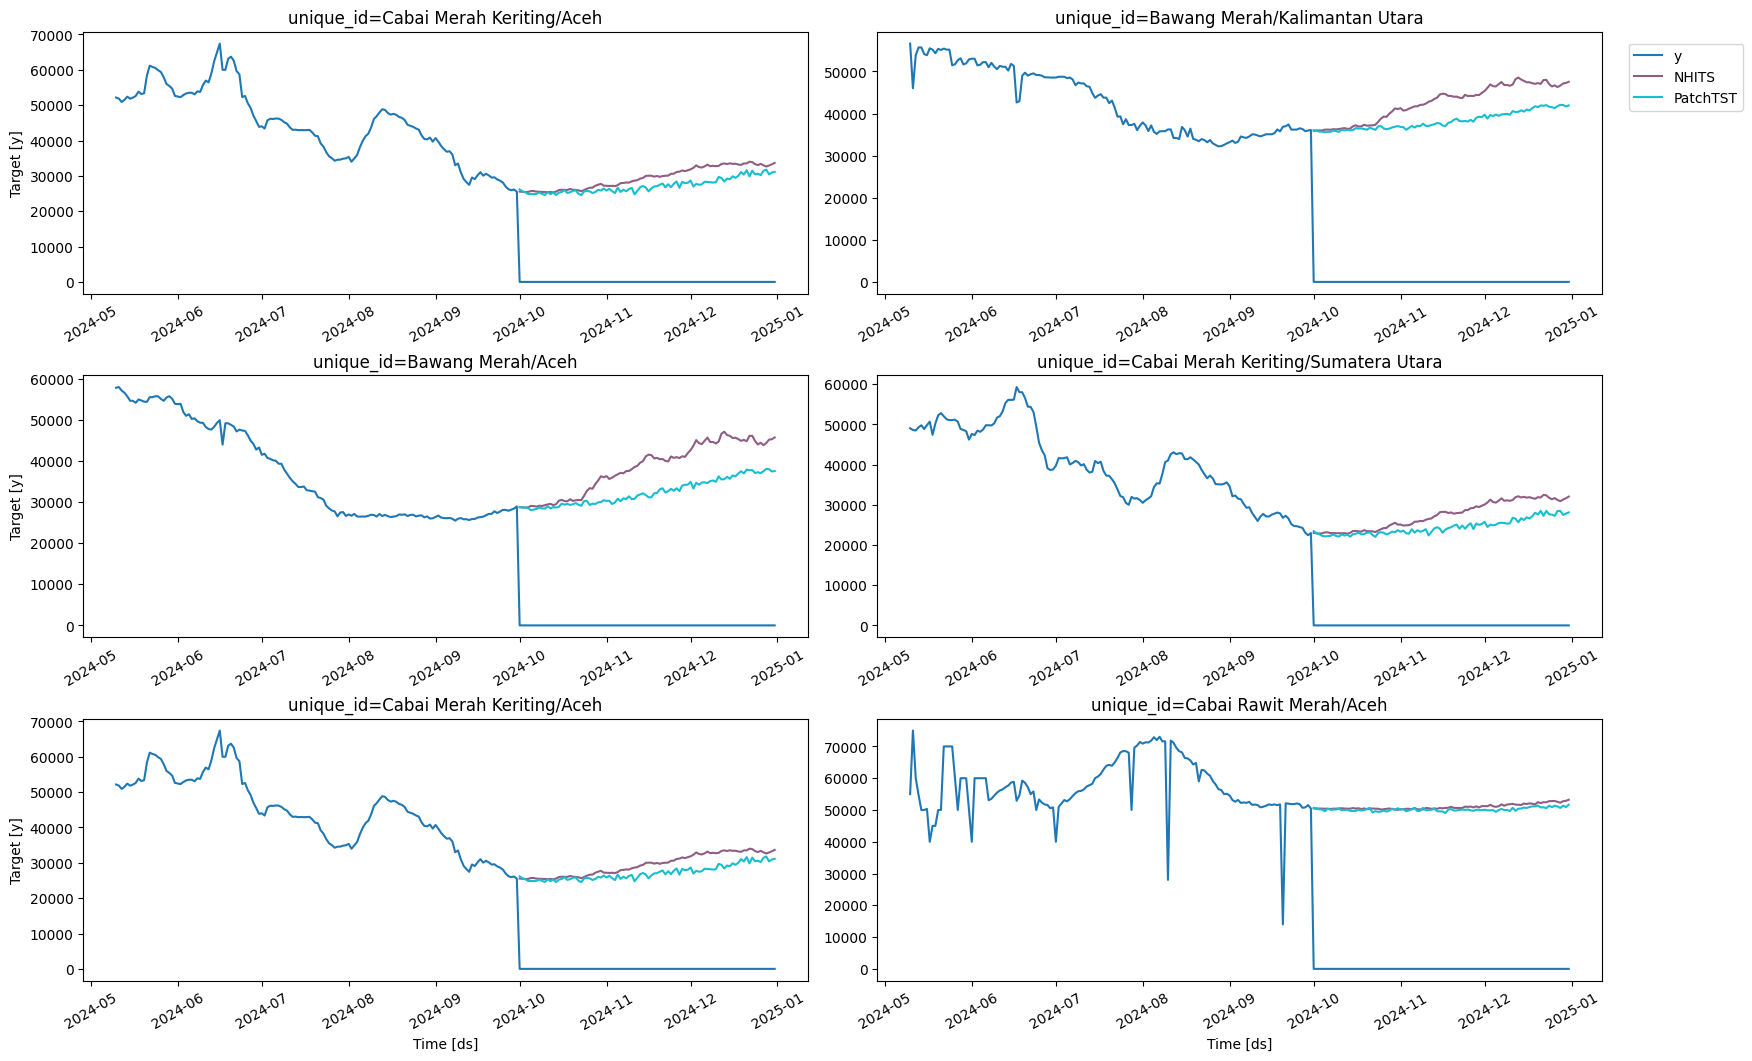

In [56]:
plot_series(train_df[['unique_id','ds','y']], submission[['unique_id','ds','y','NHITS','PatchTST']],
            plot_random=False, ids=['Cabai Merah Keriting/Aceh','Bawang Merah/Kalimantan Utara','Bawang Merah/Aceh','Cabai Merah Keriting/Sumatera Utara','Cabai Merah Keriting/Aceh','Cabai Rawit Merah/Aceh'],max_insample_length=48 * 3)

In [57]:
submission = submission.sort_values(['unique_id','ds'])
submission[:30] 

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


y         ds          unique_id  Crude_Oil_WTI  Natural_Gas  \
28152  0.0 2024-10-01  Bawang Merah/Aceh            NaN          NaN   
28153  0.0 2024-10-02  Bawang Merah/Aceh            NaN          NaN   
28154  0.0 2024-10-03  Bawang Merah/Aceh            NaN          NaN   
28155  0.0 2024-10-04  Bawang Merah/Aceh            NaN          NaN   
28156  0.0 2024-10-05  Bawang Merah/Aceh            NaN          NaN   
28157  0.0 2024-10-06  Bawang Merah/Aceh            NaN          NaN   
28158  0.0 2024-10-07  Bawang Merah/Aceh            NaN          NaN   
28159  0.0 2024-10-08  Bawang Merah/Aceh            NaN          NaN   
28160  0.0 2024-10-09  Bawang Merah/Aceh            NaN          NaN   
28161  0.0 2024-10-10  Bawang Merah/Aceh            NaN          NaN   
28162  0.0 2024-10-11  Bawang Merah/Aceh            NaN          NaN   
28163  0.0 2024-10-12  Bawang Merah/Aceh            NaN          NaN   
28164  0.0 2024-10-13  Bawang Merah/Aceh            NaN          NaN   
28165  0.0 2024-10-14  Bawang Merah/Aceh            NaN          NaN   
28166  0.0 2024-10-15  Bawang Merah/Aceh            NaN          NaN   
28167  0.0 2024-10-16  Bawang Merah/Aceh            NaN          NaN   
28168  0.0 2024-10-17  Bawang Merah/Aceh            NaN          NaN   
28169  0.0 2024-10-18  Bawang Merah/Aceh            NaN          NaN   
28170  0.0 2024-10-19  Bawang Merah/Aceh            NaN          NaN   
28171  0.0 2024-10-20  Bawang Merah/Aceh            NaN          NaN   
28172  0.0 2024-10-21  Bawang Merah/Aceh            NaN          NaN   
28173  0.0 2024-10-22  Bawang Merah/Aceh            NaN          NaN   
28174  0.0 2024-10-23  Bawang Merah/Aceh            NaN          NaN   
28175  0.0 2024-10-24  Bawang Merah/Aceh            NaN          NaN   
28176  0.0 2024-10-25  Bawang Merah/Aceh            NaN          NaN   
28177  0.0 2024-10-26  Bawang Merah/Aceh            NaN          NaN   
28178  0.0 2024-10-27  Bawang Merah/Aceh            NaN          NaN   
28179  0.0 2024-10-28  Bawang Merah/Aceh            NaN          NaN   
28180  0.0 2024-10-29  Bawang Merah/Aceh            NaN          NaN   
28181  0.0 2024-10-30  Bawang Merah/Aceh            NaN          NaN   

       Newcastle_Coal  US_Sugar_11  USD_IDR  is_holiday  prev_day_holiday  \
28152             NaN          NaN      NaN           0                 0   
28153             NaN          NaN      NaN           0                 0   
28154             NaN          NaN      NaN           0                 0   
28155             NaN          NaN      NaN           0                 0   
28156             NaN          NaN      NaN           0                 0   
28157             NaN          NaN      NaN           0                 0   
28158             NaN          NaN      NaN           0                 0   
28159             NaN          NaN      NaN           0                 0   
28160             NaN          NaN      NaN           0                 0   
28161             NaN          NaN      NaN           0                 0   
28162             NaN          NaN      NaN           0                 0   
28163             NaN          NaN      NaN           0                 0   
28164             NaN          NaN      NaN           0                 0   
28165             NaN          NaN      NaN           0                 0   
28166             NaN          NaN      NaN           0                 0   
28167             NaN          NaN      NaN           0                 0   
28168             NaN          NaN      NaN           0                 0   
28169             NaN          NaN      NaN           0                 0   
28170             NaN          NaN      NaN           0                 0   
28171             NaN          NaN      NaN           0                 0   
28172             NaN          NaN      NaN           0                 0   
28173             NaN          NaN      NaN           0                 0   
28174

In [58]:
submission[60:90] # del < july val pad

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


y         ds          unique_id  Crude_Oil_WTI  Natural_Gas  \
28212  0.0 2024-11-30  Bawang Merah/Aceh            NaN          NaN   
28213  0.0 2024-12-01  Bawang Merah/Aceh            NaN          NaN   
28214  0.0 2024-12-02  Bawang Merah/Aceh            NaN          NaN   
28215  0.0 2024-12-03  Bawang Merah/Aceh            NaN          NaN   
28216  0.0 2024-12-04  Bawang Merah/Aceh            NaN          NaN   
28217  0.0 2024-12-05  Bawang Merah/Aceh            NaN          NaN   
28218  0.0 2024-12-06  Bawang Merah/Aceh            NaN          NaN   
28219  0.0 2024-12-07  Bawang Merah/Aceh            NaN          NaN   
28220  0.0 2024-12-08  Bawang Merah/Aceh            NaN          NaN   
28221  0.0 2024-12-09  Bawang Merah/Aceh            NaN          NaN   
28222  0.0 2024-12-10  Bawang Merah/Aceh            NaN          NaN   
28223  0.0 2024-12-11  Bawang Merah/Aceh            NaN          NaN   
28224  0.0 2024-12-12  Bawang Merah/Aceh            NaN          NaN   
28225  0.0 2024-12-13  Bawang Merah/Aceh            NaN          NaN   
28226  0.0 2024-12-14  Bawang Merah/Aceh            NaN          NaN   
28227  0.0 2024-12-15  Bawang Merah/Aceh            NaN          NaN   
28228  0.0 2024-12-16  Bawang Merah/Aceh            NaN          NaN   
28229  0.0 2024-12-17  Bawang Merah/Aceh            NaN          NaN   
28230  0.0 2024-12-18  Bawang Merah/Aceh            NaN          NaN   
28231  0.0 2024-12-19  Bawang Merah/Aceh            NaN          NaN   
28232  0.0 2024-12-20  Bawang Merah/Aceh            NaN          NaN   
28233  0.0 2024-12-21  Bawang Merah/Aceh            NaN          NaN   
28234  0.0 2024-12-22  Bawang Merah/Aceh            NaN          NaN   
28235  0.0 2024-12-23  Bawang Merah/Aceh            NaN          NaN   
28236  0.0 2024-12-24  Bawang Merah/Aceh            NaN          NaN   
28237  0.0 2024-12-25  Bawang Merah/Aceh            NaN          NaN   
28238  0.0 2024-12-26  Bawang Merah/Aceh            NaN          NaN   
28239  0.0 2024-12-27  Bawang Merah/Aceh            NaN          NaN   
28240  0.0 2024-12-28  Bawang Merah/Aceh            NaN          NaN   
28241  0.0 2024-12-29  Bawang Merah/Aceh            NaN          NaN   

       Newcastle_Coal  US_Sugar_11  USD_IDR  is_holiday  prev_day_holiday  \
28212             NaN          NaN      NaN           0                 0   
28213             NaN          NaN      NaN           0                 0   
28214             NaN          NaN      NaN           0                 0   
28215             NaN          NaN      NaN           0                 0   
28216             NaN          NaN      NaN           0                 0   
28217             NaN          NaN      NaN           0                 0   
28218             NaN          NaN      NaN           0                 0   
28219             NaN          NaN      NaN           0                 0   
28220             NaN          NaN      NaN           0                 0   
28221             NaN          NaN      NaN           0                 0   
28222             NaN          NaN      NaN           0                 0   
28223             NaN          NaN      NaN           0                 0   
28224             NaN          NaN      NaN           0                 0   
28225             NaN          NaN      NaN           0                 0   
28226             NaN          NaN      NaN           0                 0   
28227             NaN          NaN      NaN           0                 0   
28228             NaN          NaN      NaN           0                 0   
28229             NaN          NaN      NaN           0                 0   
28230             NaN          NaN      NaN           0                 0   
28231             NaN          NaN      NaN           0                 0   
28232             NaN          NaN      NaN           0                 0   
28233             NaN          NaN      NaN           0                 0   
28234

## Combine

In [12]:
def get_best_model_forecast(forecasts_df, evaluation_df, metric):
    metric_eval = evaluation_df.loc[evaluation_df['metric'] == metric, ['unique_id', 'best_model']]
    with_best = forecasts_df.merge(metric_eval)
    res = with_best[['unique_id', 'ds']].copy()
    res['best_model'] = with_best.apply(lambda row: row[row['best_model']], axis=1)
    return res

In [17]:
prod_forecasts_df = get_best_model_forecast(submission, evaluation_df, metric='mape')


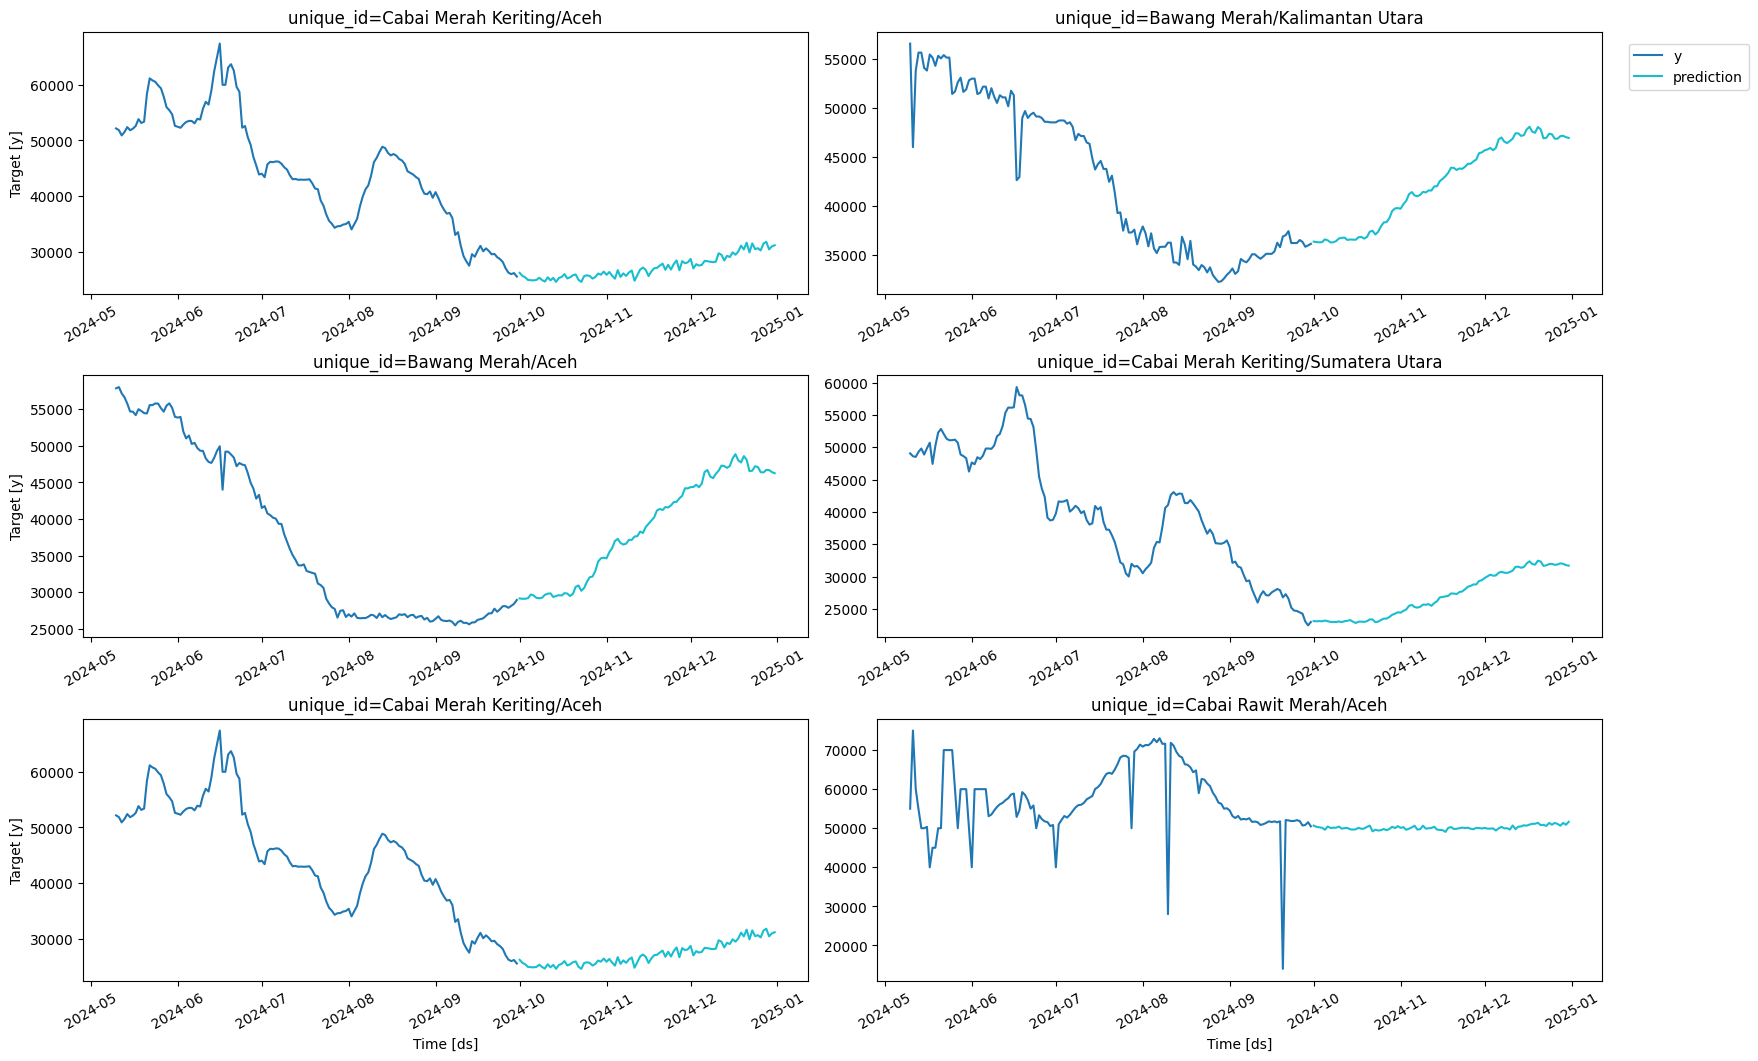

In [18]:
from utilsforecast.plotting import plot_series
submission['prediction'] = prod_forecasts_df['best_model'].values  

plot_series(train_df[['unique_id','ds','y']], submission[['unique_id','ds','prediction']],
            plot_random=False, ids=['Cabai Merah Keriting/Aceh','Bawang Merah/Kalimantan Utara','Bawang Merah/Aceh','Cabai Merah Keriting/Sumatera Utara','Cabai Merah Keriting/Aceh','Cabai Rawit Merah/Aceh'],max_insample_length=48 * 3)


In [61]:
prod_forecasts_df['id'] = prod_forecasts_df['unique_id'] + '/' + prod_forecasts_df['ds'].dt.strftime('%Y-%m-%d')
prod_forecasts_df = prod_forecasts_df[['id', 'best_model']].rename(columns={'best_model': 'price'})
prod_forecasts_df = prod_forecasts_df.sort_values('id')
prod_forecasts_df[:30]

id         price
0   Bawang Merah/Aceh/2024-10-01  28820.457031
1   Bawang Merah/Aceh/2024-10-02  28693.220703
2   Bawang Merah/Aceh/2024-10-03  28657.878906
3   Bawang Merah/Aceh/2024-10-04  28572.083984
4   Bawang Merah/Aceh/2024-10-05  28019.984375
5   Bawang Merah/Aceh/2024-10-06  28162.871094
6   Bawang Merah/Aceh/2024-10-07  28322.660156
7   Bawang Merah/Aceh/2024-10-08  28708.175781
8   Bawang Merah/Aceh/2024-10-09  28464.103516
9   Bawang Merah/Aceh/2024-10-10  28433.224609
10  Bawang Merah/Aceh/2024-10-11  28976.529297
11  Bawang Merah/Aceh/2024-10-12  28468.878906
12  Bawang Merah/Aceh/2024-10-13  28788.976562
13  Bawang Merah/Aceh/2024-10-14  28672.056641
14  Bawang Merah/Aceh/2024-10-15  28857.976562
15  Bawang Merah/Aceh/2024-10-16  29632.812500
16  Bawang Merah/Aceh/2024-10-17  29388.539062
17  Bawang Merah/Aceh/2024-10-18  29552.751953
18  Bawang Merah/Aceh/2024-10-19  29326.062500
19  Bawang Merah/Aceh/2024-10-20  29461.029297
20  Bawang Merah/Aceh/2024-10-21  29771.029297
21  Bawang Merah/Aceh/2024-10-22  29378.546875
22  Bawang Merah/Aceh/2024-10-23  29103.062500
23  Bawang Merah/Aceh/2024-10-24  30261.673828
24  Bawang Merah/Aceh/2024-10-25  30306.000000
25  Bawang Merah/Aceh/2024-10-26  29303.453125
26  Bawang Merah/Aceh/2024-10-27  29621.396484
27  Bawang Merah/Aceh/2024-10-28  29541.208984
28  Bawang Merah/Aceh/2024-10-29  29953.640625
29  Bawang Merah/Aceh/2024-10-30  30018.121094

In [62]:
prod_forecasts_df.to_csv('nhits_patchtst_hol.csv', index=False)
print("PatchTST submission created successfully!")


PatchTST submission created successfully!
